In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import time
from gower import gower_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from torch.utils.data import Dataset, DataLoader
import time  
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from dotenv import load_dotenv
import neptune
import optuna
import time  
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score, mean_squared_error, make_scorer
import shap
import umap
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression

# 1. Изучаем датасет. Удаляем или заполняем пропуски/NAN.

In [3]:
df_house = pd.read_csv('content/dataset_1_lesson.csv')

In [4]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df_house

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

### Много нулевых данных. В силу того что NAN в данном датасете это просто отсутсвие признака (например гаража) у конрктного здания их нужноне удалять а вынести в отдельны параметр а затем кодировать

In [6]:
df_encoded = df_house.copy()
label_encoders = {}

# Находим категориальные признаки
categorical_columns = df_encoded.select_dtypes(include=['object']).columns

# Заменяем NaN на строку 'Missing' и применяем LabelEncoder
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].fillna('Missing')  
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Отсутствующие данные в числовых столбцах заменяем медианой
for col in df_encoded.select_dtypes(include=['int64', 'float64']).columns:
    df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())

## 2. Строим матрицу корреляции

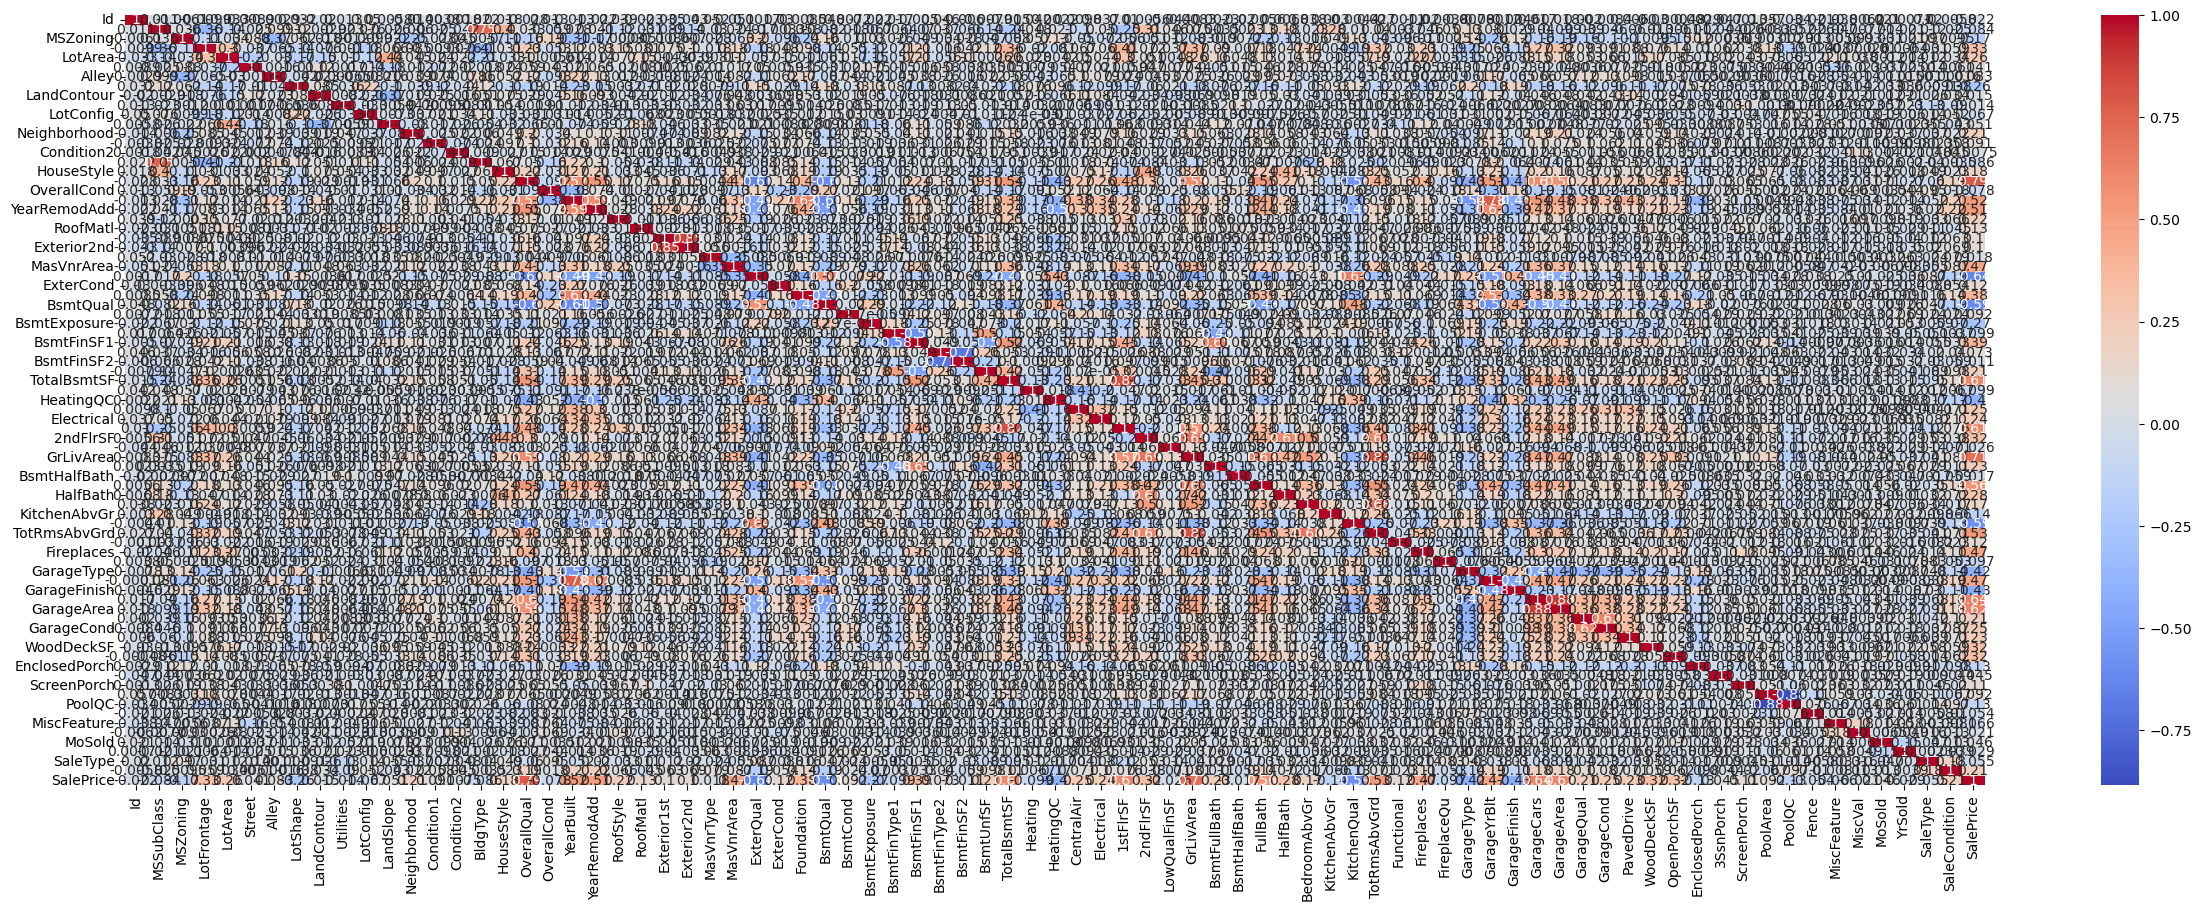

In [7]:
plt.figure(figsize=(30, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.show()

In [8]:
df_encoded.corr()

Id  MSSubClass  MSZoning  LotFrontage   LotArea  \
Id             1.000000    0.011156 -0.006096    -0.009921 -0.033226   
MSSubClass     0.011156    1.000000  0.035900    -0.356718 -0.139781   
MSZoning      -0.006096    0.035900  1.000000    -0.105961 -0.034452   
LotFrontage   -0.009921   -0.356718 -0.105961     1.000000  0.304522   
LotArea       -0.033226   -0.139781 -0.034452     0.304522  1.000000   
...                 ...         ...       ...          ...       ...   
MoSold         0.021172   -0.013585 -0.031496     0.010451  0.001205   
YrSold         0.000712   -0.021407 -0.020628     0.006380 -0.014261   
SaleType       0.019773    0.012464  0.097437    -0.031412  0.012292   
SaleCondition -0.005806   -0.024940  0.009494     0.058857  0.034169   
SalePrice     -0.021917   -0.084284 -0.166872     0.334771  0.263843   

                 Street     Alley  LotShape  LandContour  Utilities  ...  \
Id             0.008916 -0.002855  0.032122    -0.019659   0.013324  ...   
MSSubClass    -0.024969  0.099430  0.119289    -0.002940  -0.022844  ...   
MSZoning       0.087654 -0.368086  0.061887    -0.017854  -0.001192  ...   
LotFrontage   -0.037349 -0.065084 -0.138877    -0.076080  -0.001027  ...   
LotArea       -0.197131 -0.029676 -0.165315    -0.149083   0.010123  ...   
...                 ...       ...       ...          ...        ...  ...   
MoSold         0.003690 -0.011274 -0.033455    -0.011599  -0.051552  ...   
YrSold        -0.025043  0.015176  0.036449     0.020507   0.023353  ...   
SaleType       0.014339  0.001092 -0.000911    -0.025754  -0.126770  ...   
SaleCondition  0.006064 -0.000162 -0.038118     0.033809  -0.089701  ...   
SalePrice      0.041036  0.083121 -0.255580     0.015453  -0.014314  ...   

               PoolArea    PoolQC     Fence  MiscFeature   MiscVal    MoSold  \
Id             0.057044 -0.033928 -0.020950    -0.038103 -0.006242  0.021172   
MSSubClass     0.008283 -0.005221 -0.025510    -0.046881 -0.007683 -0.013585   
MSZoning      -0.003128  0.002882  0.012710    -0.005553  0.009293 -0.031496   
LotFrontage    0.180819 -0.191902 -0.023818     0.008677 -0.000255  0.010451   
LotArea        0.077672 -0.065167 -0.022092     0.106135  0.038068  0.001205   
...                 ...       ...       ...          ...       ...       ...   
MoSold        -0.033737  0.036368 -0.027206     0.013957 -0.006495  1.000000   
YrSold        -0.059689  0.060904  0.014492     0.057708  0.004906 -0.145721   
SaleType       0.011009 -0.013592 -0.005779    -0.003340  0.015773 -0.047386   
SaleCondition -0.067251  0.097425 -0.010082    -0.008074  0.013027  0.013320   
SalePrice      0.092404 -0.126070 -0.054318    -0.066316 -0.021190  0.046432   

                 YrSold  SaleType  SaleCondition  SalePrice  
Id             0.000712  0.019773      -0.005806  -0.021917  
MSSubClass    -0.021407  0.012464      -0.024940  -0.084284  
MSZoning      -0.020628  0.097437       0.009494  -0.166872  
LotFrontage    0.006380 -0.031412       0.058857   0.334771  
LotArea       -0.014261  0.012292       0.034169   0.263843  
...                 ...       ...            ...        ...  
MoSold        -0.145721 -0.047386       0.013320   0.046432  
YrSold         1.000000 -0.002327       0.003880  -0.028923  
SaleType      -0.002327  1.000000       0.184067  -0.054911  
SaleCondition  0.003880  0.184067       1.000000   0.213092  
SalePrice     -0.028923 -0.054911       0.213092   1.000000  

[81 rows x 81 columns]

## Данных очень много. И много связанных поэтому протестируем MI  и затем примем решение

## 3. Выделяем матрицу признаков и целевую переменную

In [9]:
# Убираем целевую переменную 
X = df_encoded.drop(columns=['SalePrice'])
y = df_encoded.SalePrice

## 4. Проверяем MI

In [10]:
mi_scores = mutual_info_regression(X, y)

# Оформляем результат в DataFrame
mi_scores = pd.Series(mi_scores, index=df_encoded.drop(columns=['SalePrice']).columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Печатаем все MI-оценки
print("📊 Mutual Information Scores:")
print(mi_scores)

# Выводим признаки с низкой важностью (MI < 0.01)
low_mi = mi_scores[mi_scores < 0.01]

print("\n Features with MI < 0.01 (Очень низкие значения):")
print(low_mi)

📊 Mutual Information Scores:
OverallQual     0.555069
Neighborhood    0.504324
GrLivArea       0.483992
YearBuilt       0.368240
TotalBsmtSF     0.367133
                  ...   
PoolArea        0.000000
3SsnPorch       0.000000
Condition2      0.000000
Functional      0.000000
Id              0.000000
Length: 80, dtype: float64

 Features with MI < 0.01 (Очень низкие значения):
RoofStyle      0.009326
PoolQC         0.006634
RoofMatl       0.006042
Utilities      0.004259
MiscFeature    0.003026
BsmtFinSF2     0.002406
YrSold         0.000000
Street         0.000000
MoSold         0.000000
LandSlope      0.000000
PoolArea       0.000000
3SsnPorch      0.000000
Condition2     0.000000
Functional     0.000000
Id             0.000000
dtype: float64


### Чистим данные от признаком с нулевым MI (MiscFeature, Street, MoSold, Utilities, 3SsnPorch, RoofMatl, Functional, Condition2, Id) для не нуелвого еще потестируем.

In [11]:
low_mi_features = [
    'PoolQC', 'BsmtFinSF2', 'MiscVal', 'PoolArea', 
    'YrSold', 'ExterCond', 'LowQualFinSF'
]

In [12]:
for feature in low_mi_features:
    corr = df_encoded[[feature, 'SalePrice']].corr().iloc[0, 1]
    unique_vals = df_house[feature].nunique()
    missing_ratio = df_house[feature].isnull().mean()
    
    print(f"{feature}:")
    print(f"  Корреляция с SalePrice: {corr:.4f}")
    print(f"  Уникальных значений: {unique_vals}")
    print(f"  Доля пропусков: {missing_ratio:.4f}")
    print("-" * 40)

PoolQC:
  Корреляция с SalePrice: -0.1261
  Уникальных значений: 3
  Доля пропусков: 0.9952
----------------------------------------
BsmtFinSF2:
  Корреляция с SalePrice: -0.0114
  Уникальных значений: 144
  Доля пропусков: 0.0000
----------------------------------------
MiscVal:
  Корреляция с SalePrice: -0.0212
  Уникальных значений: 21
  Доля пропусков: 0.0000
----------------------------------------
PoolArea:
  Корреляция с SalePrice: 0.0924
  Уникальных значений: 8
  Доля пропусков: 0.0000
----------------------------------------
YrSold:
  Корреляция с SalePrice: -0.0289
  Уникальных значений: 5
  Доля пропусков: 0.0000
----------------------------------------
ExterCond:
  Корреляция с SalePrice: 0.1173
  Уникальных значений: 5
  Доля пропусков: 0.0000
----------------------------------------
LowQualFinSF:
  Корреляция с SalePrice: -0.0256
  Уникальных значений: 24
  Доля пропусков: 0.0000
----------------------------------------


100% удаление:
PoolQC - Закодирована как категориальная с 'Missing', но почти полностью пропущена — можно удалить.
LowQualFinSF - Пропусков: 0%, но низкая MI и почти нулевая корреляция — можно удалить.

Сомнительные:
BsmtFinSF2 - Много значений, низкая корреляция и низкий MI → скорее удалить, если не влияет на модель.
MiscVal - Почти нет связи с целевой. удаляем.

Можно оставить:
PoolArea - Корреляция чуть выше → оставить, но возможно проверить.
ExterCond -Даже с низкой MI, визуально и по логике может быть значим → оставить.
YrSold - Хронологический признак → может быть полезен в ансамблях → оставить для проверки.



In [13]:
# Данные по "спорным" признакам
feature_analysis = [
    {"Feature": "PoolQC", "Corr": -0.1261, "Unique": 3, "MissingRatio": 0.9952, "Drop": True},
    {"Feature": "BsmtFinSF2", "Corr": -0.0114, "Unique": 144, "MissingRatio": 0.0000, "Drop": True},
    {"Feature": "MiscVal", "Corr": -0.0212, "Unique": 21, "MissingRatio": 0.0000, "Drop": True},
    {"Feature": "PoolArea", "Corr": 0.0924, "Unique": 8, "MissingRatio": 0.0000, "Drop": False},
    {"Feature": "YrSold", "Corr": -0.0289, "Unique": 5, "MissingRatio": 0.0000, "Drop": False},
    {"Feature": "ExterCond", "Corr": 0.1173, "Unique": 5, "MissingRatio": 0.0000, "Drop": False},
    {"Feature": "LowQualFinSF", "Corr": -0.0256, "Unique": 24, "MissingRatio": 0.0000, "Drop": True},
]

df_feature_analysis = pd.DataFrame(feature_analysis)
print(df_feature_analysis)

        Feature    Corr  Unique  MissingRatio   Drop
0        PoolQC -0.1261       3        0.9952   True
1    BsmtFinSF2 -0.0114     144        0.0000   True
2       MiscVal -0.0212      21        0.0000   True
3      PoolArea  0.0924       8        0.0000  False
4        YrSold -0.0289       5        0.0000  False
5     ExterCond  0.1173       5        0.0000  False
6  LowQualFinSF -0.0256      24        0.0000   True


In [14]:
# Список на удаление
features_to_drop = df_feature_analysis[df_feature_analysis["Drop"] == True]["Feature"].tolist()

In [15]:
df_encoded = df_encoded.drop(columns=features_to_drop)


In [16]:
X = df_encoded.drop(columns=['SalePrice'])

## 5. Проверяем мультиколлинеарность VIF.

In [17]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

Feature           VIF
1      MSSubClass     14.971046
2        MSZoning     36.162336
3     LotFrontage     19.392620
5          Street    285.932328
6           Alley     21.687748
8     LandContour     21.548359
14     Condition2     66.267549
17    OverallQual     80.168004
18    OverallCond     51.182997
19      YearBuilt  34948.673527
20   YearRemodAdd  26491.385436
23    Exterior1st     40.650334
24    Exterior2nd     38.631283
25     MasVnrType     12.869871
27      ExterQual     38.876398
28      ExterCond     33.003694
30       BsmtQual     14.080632
31       BsmtCond     19.623001
34     BsmtFinSF1     36.947219
35   BsmtFinType2     52.555835
36      BsmtUnfSF     50.661143
37    TotalBsmtSF    129.801104
38        Heating     17.396352
40     CentralAir     27.292022
41     Electrical     17.658343
42       1stFlrSF    797.975256
43       2ndFlrSF    160.608711
44      GrLivArea   1316.867536
47       FullBath     28.999054
49   BedroomAbvGr     35.810062
50   KitchenAbvGr     41.277185
51    KitchenQual     18.647601
52   TotRmsAbvGrd     90.077649
53     Functional     44.545858
57    GarageYrBlt  25815.843204
59     GarageCars     39.591573
60     GarageArea     35.966383
61     GarageQual     56.344411
62     GarageCond     71.809359
63     PavedDrive     22.679273
70          Fence     13.915025
71    MiscFeature     10.405324
73         YrSold  44577.404607
74       SaleType     28.453350
75  SaleCondition     15.318363

In [18]:
# Функция для рекурсивного удаления признаков с высоким VIF
def recursive_vif_cleanup(X, threshold=10):
    # Инициализация пустого DataFrame для хранения данных VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns 
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Считаем количество удалённых признаков
    removed_features = 0

    # Рекурсивный процесс удаления
    while vif_data["VIF"].max() > threshold:
        # Находим признак с максимальным VIF
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax()]["Feature"]
        # Удаляем этот признак
        X = X.drop(columns=[max_vif_feature])
        
        # Пересчитываем VIF
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns 
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        
        removed_features += 1
        print(f"Удалён признак {max_vif_feature} с VIF = {vif_data['VIF'].max()}")

    # Возвращаем очищенный DataFrame и количество удалённых признаков
    return X, removed_features, vif_data


In [19]:
# Применяем функцию к нашему DataFrame
X_cleaned, removed_count, final_vif_data = recursive_vif_cleanup(X)

# Выводим результаты
print(f"Количество удалённых признаков: {removed_count}")
print(final_vif_data)

Удалён признак YrSold с VIF = 26851.58003083279
Удалён признак YearBuilt с VIF = 16013.176327198085
Удалён признак YearRemodAdd с VIF = 1277.1072753877513
Удалён признак GrLivArea с VIF = 885.3453209202936
Удалён признак GarageYrBlt с VIF = 212.59820611079823
Удалён признак Street с VIF = 126.52932176833829
Удалён признак TotalBsmtSF с VIF = 86.26803683743624
Удалён признак TotRmsAbvGrd с VIF = 73.3292536994569
Удалён признак OverallQual с VIF = 70.97631942572986
Удалён признак GarageCond с VIF = 58.96963889314231
Удалён признак Condition2 с VIF = 54.305778414475625
Удалён признак 1stFlrSF с VIF = 40.09962172889576
Удалён признак Exterior1st с VIF = 39.592099241717875
Удалён признак GarageQual с VIF = 37.74955672256943
Удалён признак GarageCars с VIF = 37.27943185406898
Удалён признак Functional с VIF = 35.68223225962307
Удалён признак ExterQual с VIF = 33.7753147899414
Удалён признак OverallCond с VIF = 33.34192896117888
Удалён признак KitchenAbvGr с VIF = 30.14805919786738
Удалён при

In [20]:
X_cleaned

Id  LotArea  LotShape  Utilities  LotConfig  LandSlope  Neighborhood  \
0        1     8450         3          0          4          0             5   
1        2     9600         3          0          2          0            24   
2        3    11250         0          0          4          0             5   
3        4     9550         0          0          0          0             6   
4        5    14260         0          0          2          0            15   
...    ...      ...       ...        ...        ...        ...           ...   
1455  1456     7917         3          0          4          0             8   
1456  1457    13175         3          0          4          0            14   
1457  1458     9042         3          0          4          0             6   
1458  1459     9717         3          0          4          0            12   
1459  1460     9937         3          0          4          0             7   

      Condition1  BldgType  HouseStyle  ...  GarageType  GarageFinish  \
0              2         0           5  ...           1             2   
1              1         0           2  ...           1             2   
2              2         0           5  ...           1             2   
3              2         0           5  ...           5             3   
4              2         0           5  ...           1             2   
...          ...       ...         ...  ...         ...           ...   
1455           2         0           5  ...           1             2   
1456           2         0           2  ...           1             3   
1457           2         0           5  ...           1             2   
1458           2         0           2  ...           1             3   
1459           2         0           2  ...           1             0   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0              0           61              0          0            0   
1            298            0              0          0            0   
2              0           42              0          0            0   
3              0           35            272          0            0   
4            192           84              0          0            0   
...          ...          ...            ...        ...          ...   
1455           0           40              0          0            0   
1456         349            0              0          0            0   
1457           0           60              0          0            0   
1458         366            0            112          0            0   
1459         736           68              0          0            0   

      PoolArea  MiscFeature  MoSold  
0            0            1       2  
1            0            1       5  
2            0            1       9  
3            0            1       2  
4            0            1      12  
...        ...          ...     ...  
1455         0            1       8  
1456         0            1       2  
1457         0            3       5  
1458         0            1       4  
1459         0            1       6  

[1460 rows x 37 columns]

## 6. Аномалии:

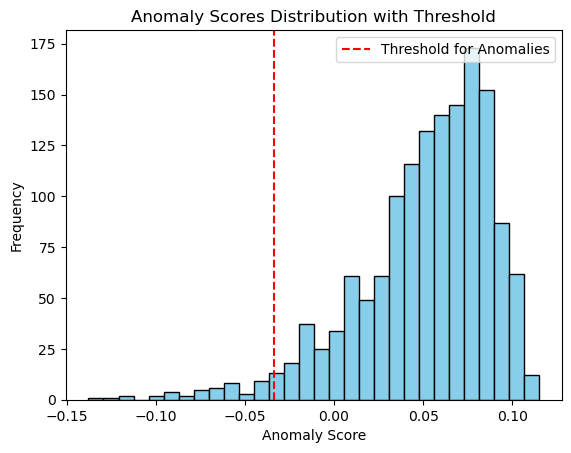

Аномалии (с динамическим порогом):
[1 1 1 ... 1 1 1]


In [21]:
# Инициализация модели Isolation Forest
iso_forest = IsolationForest(contamination=0.1)

# Обучение модели и предсказание меток (1 - нормальная точка, -1 - аномальная)
y_pred_iso = iso_forest.fit_predict(X)

# Получение аномальных баллов (чем ниже значение, тем более аномально)
anomaly_scores = iso_forest.decision_function(X)

# Визуализация гистограммы аномальных баллов
plt.hist(anomaly_scores, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.percentile(anomaly_scores, 3), color='red', linestyle='--', label='Threshold for Anomalies')
plt.title("Anomaly Scores Distribution with Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Динамическое определение порога для аномалий на основе 5% наименьших значений
threshold = np.percentile(anomaly_scores, 3)  # Для выделения 5% самых аномальных точек

# Классификация на основе динамического порога
y_pred_custom = (anomaly_scores > threshold).astype(int)  # 1 - нормальные, 0 - аномальные

# Проверка результатов классификации
print("Аномалии (с динамическим порогом):")
print(y_pred_custom)

In [22]:
# Отберем нормальные индексы чтобы удалить аномалии из датасета
normal_indices = np.where(y_pred_custom == 1)[0]

# Создание нового датасета без аномалий (отбор только нормальных точек)
X_without_anomalies = X.iloc[normal_indices]  # Используем iloc для правильного индексирования строк
y_without_anomalies = y.iloc[normal_indices]  # Если y - это DataFrame или Series

# Проверка размера нового датасета
print("Размер исходного датасета:", X.shape)
print("Размер датасета без аномалий:", X_without_anomalies.shape)

Размер исходного датасета: (1460, 76)
Размер датасета без аномалий: (1416, 76)


## 7.  Нормализация

In [23]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_without_anomalies)
df_x_scaler = pd.DataFrame(X_scaler, columns=X_without_anomalies.columns) 

## 8. Понижение размерности. Т.к это регрессия будем пробовать через PCA

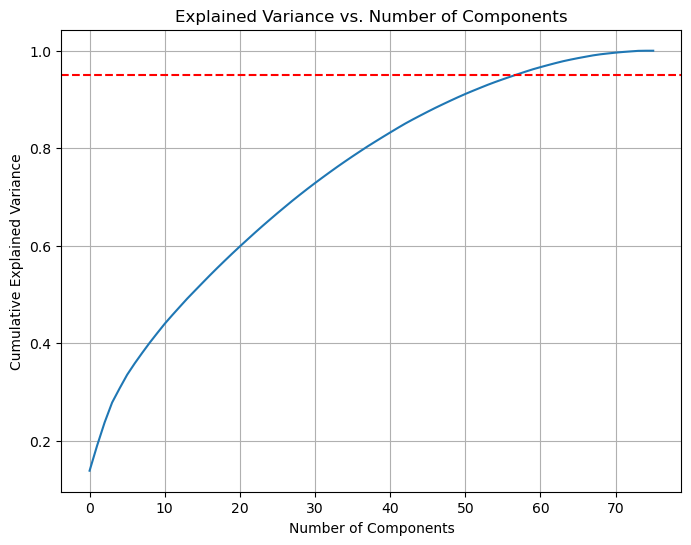

In [24]:
pca = PCA().fit(X_scaler)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--')  # Добавляем линию для 95%
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### График показывает что данные не сильно структурированы и, поэтому, не выгодно использовать PCA для уменьшения размерности.

In [25]:
# Применяем UMAP для понижения размерности
umap_model = umap.UMAP(n_components=2)  # Уменьшаем размерность до 2 для визуализации
X_umap = umap_model.fit_transform(X_scaler)

umap_coordinates = umap_model.embedding_

# Преобразуем в DataFrame для удобного отображения
df_umap = pd.DataFrame(umap_coordinates, columns=['UMAP1', 'UMAP2'])

# Присоединим целевую переменную для анализа
df_umap['SalePrice'] = y_without_anomalies

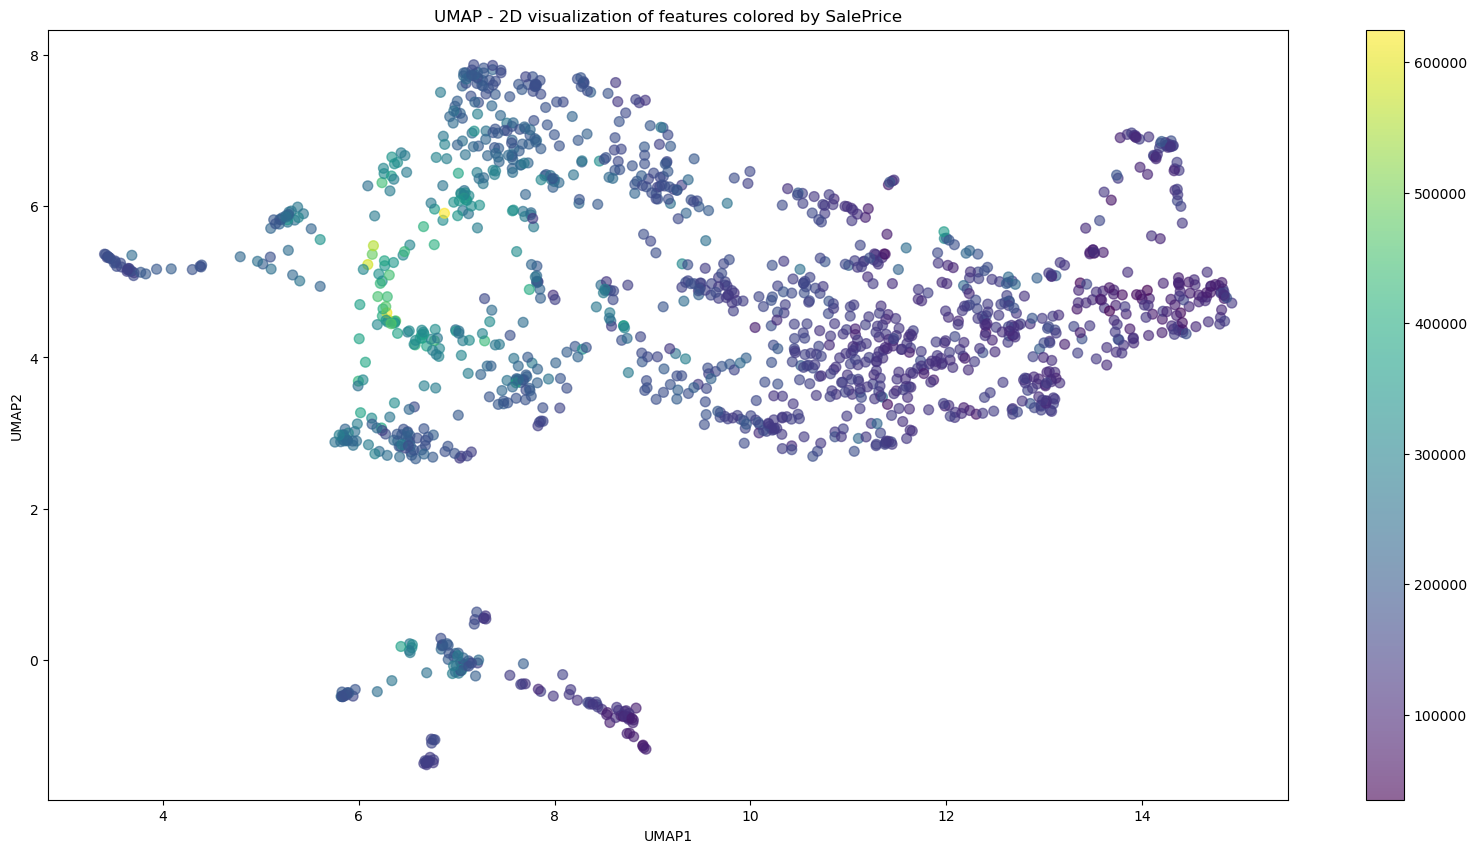

In [26]:
# Визуализируем данные с цветовой кодировкой по SalePrice (y)
plt.figure(figsize=(20, 10))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=y_without_anomalies, cmap='viridis', s=50, alpha=0.6)
plt.colorbar()  # Добавляем цветовую шкалу
plt.title('UMAP - 2D visualization of features colored by SalePrice')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

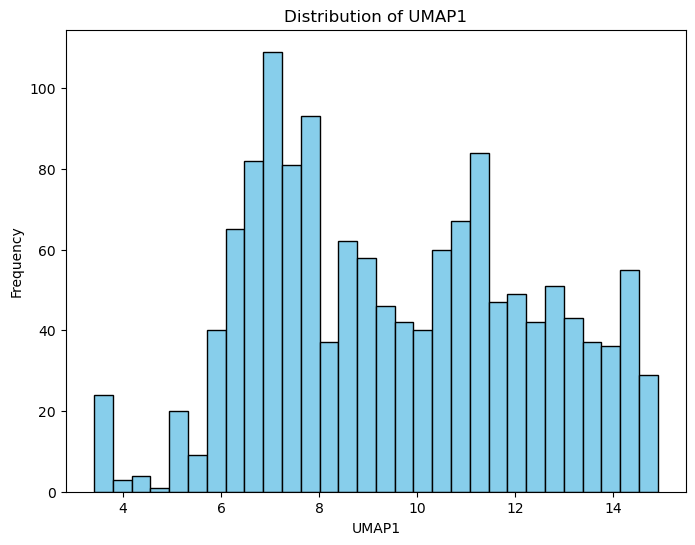

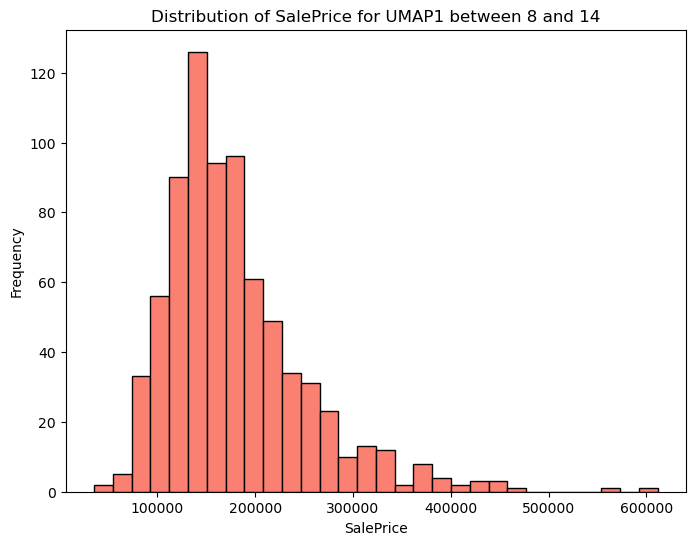

In [27]:
# Строим гистограмму для UMAP1
plt.figure(figsize=(8, 6))
plt.hist(df_umap['UMAP1'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of UMAP1')
plt.xlabel('UMAP1')
plt.ylabel('Frequency')
plt.show()

# Строим гистограмму для SalePrice в диапазоне UMAP1 от 8 до 14
df_filtered = df_umap[(df_umap['UMAP1'] >= 8) & (df_umap['UMAP1'] <= 14)]

plt.figure(figsize=(8, 6))
plt.hist(df_filtered['SalePrice'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of SalePrice for UMAP1 between 8 and 14')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

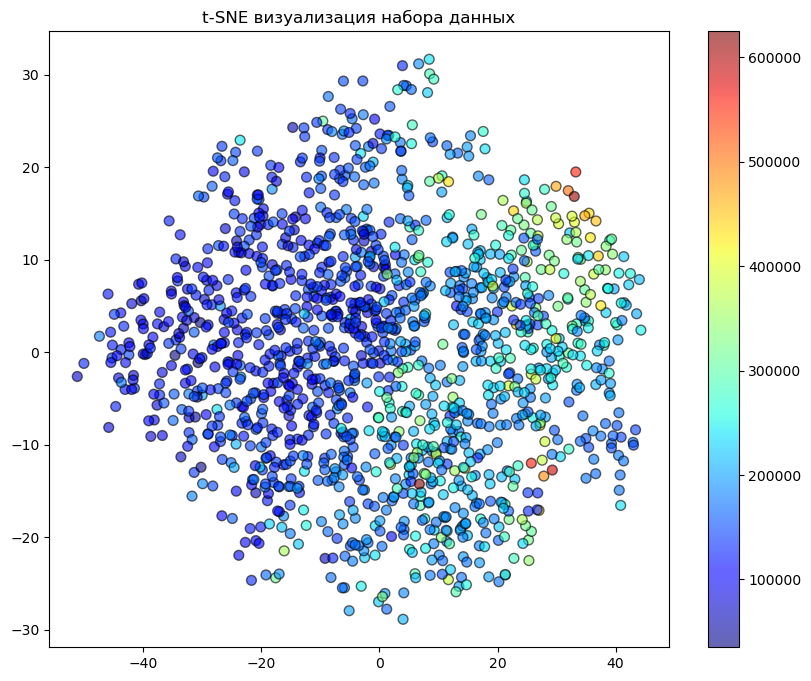

In [28]:
X_tsne = TSNE(n_components=3, random_state=42).fit_transform(X_scaler)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_without_anomalies, edgecolors='k', cmap='jet', s=50, alpha=0.6)
plt.colorbar()
plt.title('t-SNE визуализация набора данных')
plt.show()

### Очень интересно, но ничгео не понятно

## 8.1 Понижение размерности через Autoencoder

In [29]:
X_tensor = torch.tensor(X_scaler, dtype=torch.float32)

In [30]:
# Определим модель автоэнкодера
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation_fn):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
# Функция для определения потерь и оптимизатора
def objective(trial):
    # Подбор гиперпараметров
    learning_rate = trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_dim = trial.suggest_int("hidden_dim", 2, 250)
    layers = trial.suggest_categorical("layers", [35, 50, 75, 100, 250, 350, 500])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    criterion_name = trial.suggest_categorical("criterion", ["HuberLoss", "MSELoss"])

    # Выбираем активационную функцию
    if activation == "relu":
        activation_fn = nn.ReLU
    else:
        activation_fn = nn.LeakyReLU

    # Создаем модель с выбранными параметрами
    model = Autoencoder(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, activation_fn=activation_fn)

    # Выбираем оптимизатор
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Выбираем функцию потерь
    if criterion_name == "MSELoss":
        criterion = nn.MSELoss()
    else:
        criterion = nn.HuberLoss()

    # Делаем обучение
    num_epochs = 50
    lowest_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        output = model(X_tensor)
        loss = criterion(output, X_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        if loss.item() < lowest_loss:
            lowest_loss = loss.item()

    # Возвращаем ошибку для оптимизации
    return lowest_loss

In [32]:
# Запуск подбора гиперпараметров с помощью Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Выводим результаты
print(f'Лучшие параметры: {study.best_params}')
print(f'Лучший результат ошибки: {study.best_value}')

[I 2025-04-05 16:09:01,920] A new study created in memory with name: no-name-655b4062-0373-4d08-908c-382f750097b8
[I 2025-04-05 16:09:02,398] Trial 0 finished with value: 0.8070700764656067 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_dim': 61, 'layers': 350, 'dropout': 0.2919838933498906, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.8070700764656067.


Epoch [10/50], Loss: 1.0170
Epoch [20/50], Loss: 0.9289
Epoch [30/50], Loss: 0.8746
Epoch [40/50], Loss: 0.8359
Epoch [50/50], Loss: 0.8071
Epoch [10/50], Loss: 1.0000


[I 2025-04-05 16:09:02,701] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 227, 'layers': 350, 'dropout': 0.13426685129743282, 'activation': 'relu', 'optimizer': 'RMSprop', 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.8070700764656067.


Epoch [20/50], Loss: 1.0000
Epoch [30/50], Loss: 1.0000
Epoch [40/50], Loss: 1.0000
Epoch [50/50], Loss: 1.0000
Epoch [10/50], Loss: 1.2636


[I 2025-04-05 16:09:02,795] Trial 2 finished with value: 1.2576346397399902 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'hidden_dim': 3, 'layers': 50, 'dropout': 0.25361752198218157, 'activation': 'relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.8070700764656067.


Epoch [20/50], Loss: 1.2620
Epoch [30/50], Loss: 1.2605
Epoch [40/50], Loss: 1.2590
Epoch [50/50], Loss: 1.2576
Epoch [10/50], Loss: 0.8273
Epoch [20/50], Loss: 0.6845
Epoch [30/50], Loss: 0.6768


[I 2025-04-05 16:09:02,980] Trial 3 finished with value: 0.6704494953155518 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'hidden_dim': 117, 'layers': 50, 'dropout': 0.21830000322233434, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'MSELoss'}. Best is trial 3 with value: 0.6704494953155518.


Epoch [40/50], Loss: 0.6727
Epoch [50/50], Loss: 0.6704
Epoch [10/50], Loss: 0.3990
Epoch [20/50], Loss: 0.3582
Epoch [30/50], Loss: 0.3292


[I 2025-04-05 16:09:03,246] Trial 4 finished with value: 0.2848903238773346 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 249, 'layers': 250, 'dropout': 0.2480094438347246, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 4 with value: 0.2848903238773346.


Epoch [40/50], Loss: 0.3048
Epoch [50/50], Loss: 0.2849
Epoch [10/50], Loss: 0.8744
Epoch [20/50], Loss: 0.7491


[I 2025-04-05 16:09:03,478] Trial 5 finished with value: 0.707663357257843 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'hidden_dim': 135, 'layers': 35, 'dropout': 0.1042628544787802, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 4 with value: 0.2848903238773346.


Epoch [30/50], Loss: 0.7252
Epoch [40/50], Loss: 0.7139
Epoch [50/50], Loss: 0.7077
Epoch [10/50], Loss: 0.4371
Epoch [20/50], Loss: 0.4370
Epoch [30/50], Loss: 0.4369
Epoch [40/50], Loss: 0.4368


[I 2025-04-05 16:09:03,614] Trial 6 finished with value: 0.43667569756507874 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 103, 'layers': 500, 'dropout': 0.23113165838643882, 'activation': 'relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 4 with value: 0.2848903238773346.
[I 2025-04-05 16:09:03,808] Trial 7 finished with value: 0.25328823924064636 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 140, 'layers': 100, 'dropout': 0.29847827316533093, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.25328823924064636.


Epoch [50/50], Loss: 0.4367
Epoch [10/50], Loss: 0.3715
Epoch [20/50], Loss: 0.3042
Epoch [30/50], Loss: 0.2701
Epoch [40/50], Loss: 0.2593
Epoch [50/50], Loss: 0.2533


[I 2025-04-05 16:09:04,025] Trial 8 finished with value: 0.43946248292922974 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'hidden_dim': 194, 'layers': 50, 'dropout': 0.2784918252162905, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.25328823924064636.


Epoch [10/50], Loss: 0.4400
Epoch [20/50], Loss: 0.4398
Epoch [30/50], Loss: 0.4397
Epoch [40/50], Loss: 0.4396
Epoch [50/50], Loss: 0.4395
Epoch [10/50], Loss: 0.4402
Epoch [20/50], Loss: 0.4402
Epoch [30/50], Loss: 0.4402


[I 2025-04-05 16:09:04,403] Trial 9 finished with value: 0.4401668608188629 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 116, 'layers': 50, 'dropout': 0.21840189630511891, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.25328823924064636.


Epoch [40/50], Loss: 0.4402
Epoch [50/50], Loss: 0.4402
Epoch [10/50], Loss: 0.3398
Epoch [20/50], Loss: 0.3398
Epoch [30/50], Loss: 0.3398


[I 2025-04-05 16:09:04,888] Trial 10 finished with value: 0.3397755026817322 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 179, 'layers': 100, 'dropout': 0.17200630671381473, 'activation': 'relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.25328823924064636.


Epoch [40/50], Loss: 0.3398
Epoch [50/50], Loss: 0.3398
Epoch [10/50], Loss: 0.3974
Epoch [20/50], Loss: 0.3581
Epoch [30/50], Loss: 0.3296
Epoch [40/50], Loss: 0.3053


[I 2025-04-05 16:09:05,273] Trial 11 finished with value: 0.28520631790161133 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 247, 'layers': 250, 'dropout': 0.29792132145063693, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.25328823924064636.


Epoch [50/50], Loss: 0.2852
Epoch [10/50], Loss: 0.4089
Epoch [20/50], Loss: 0.3738
Epoch [30/50], Loss: 0.3467


[I 2025-04-05 16:09:05,561] Trial 12 finished with value: 0.3046143651008606 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 170, 'layers': 75, 'dropout': 0.2607136319600617, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.25328823924064636.


Epoch [40/50], Loss: 0.3244
Epoch [50/50], Loss: 0.3046
Epoch [10/50], Loss: 0.2934
Epoch [20/50], Loss: 0.2496
Epoch [30/50], Loss: 0.2393
Epoch [40/50], Loss: 0.2353


[I 2025-04-05 16:09:05,732] Trial 13 finished with value: 0.23306167125701904 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 71, 'layers': 250, 'dropout': 0.18416061192016916, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.23306167125701904.


Epoch [50/50], Loss: 0.2331
Epoch [10/50], Loss: 0.3495
Epoch [20/50], Loss: 0.2835
Epoch [30/50], Loss: 0.2585
Epoch [40/50], Loss: 0.2501


[I 2025-04-05 16:09:05,938] Trial 14 finished with value: 0.2460346519947052 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 60, 'layers': 100, 'dropout': 0.17997483941588477, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 13 with value: 0.23306167125701904.


Epoch [50/50], Loss: 0.2463
Epoch [10/50], Loss: 0.2652
Epoch [20/50], Loss: 0.2420
Epoch [30/50], Loss: 0.2356
Epoch [40/50], Loss: 0.2322


[I 2025-04-05 16:09:06,151] Trial 15 finished with value: 0.23015516996383667 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 66, 'layers': 250, 'dropout': 0.1727485204241801, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.
[I 2025-04-05 16:09:06,341] Trial 16 finished with value: 0.23244443535804749 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 62, 'layers': 250, 'dropout': 0.15919139052582332, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [50/50], Loss: 0.2302
Epoch [10/50], Loss: 0.2933
Epoch [20/50], Loss: 0.2486
Epoch [30/50], Loss: 0.2388
Epoch [40/50], Loss: 0.2347
Epoch [50/50], Loss: 0.2324


[I 2025-04-05 16:09:06,511] Trial 17 finished with value: 0.2617213726043701 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 8, 'layers': 250, 'dropout': 0.14880483847952755, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [10/50], Loss: 0.2886
Epoch [20/50], Loss: 0.2709
Epoch [30/50], Loss: 0.2659
Epoch [40/50], Loss: 0.2632
Epoch [50/50], Loss: 0.2617
Epoch [10/50], Loss: 0.2924


[I 2025-04-05 16:09:06,664] Trial 18 finished with value: 0.26455673575401306 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 34, 'layers': 250, 'dropout': 0.15016050038090012, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [20/50], Loss: 0.2785
Epoch [30/50], Loss: 0.2707
Epoch [40/50], Loss: 0.2672
Epoch [50/50], Loss: 0.2646
Epoch [10/50], Loss: 0.3070
Epoch [20/50], Loss: 0.2544


[I 2025-04-05 16:09:06,875] Trial 19 finished with value: 0.23407773673534393 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 87, 'layers': 75, 'dropout': 0.11252614541881369, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [30/50], Loss: 0.2417
Epoch [40/50], Loss: 0.2368
Epoch [50/50], Loss: 0.2341
Epoch [10/50], Loss: 0.3535
Epoch [20/50], Loss: 0.3000
Epoch [30/50], Loss: 0.2659
Epoch [40/50], Loss: 0.2504


[I 2025-04-05 16:09:07,013] Trial 20 finished with value: 0.24204841256141663 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'hidden_dim': 30, 'layers': 500, 'dropout': 0.19457026667955715, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.
[I 2025-04-05 16:09:07,161] Trial 21 finished with value: 0.23071900010108948 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 77, 'layers': 250, 'dropout': 0.16920966520057024, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [50/50], Loss: 0.2420
Epoch [10/50], Loss: 0.2996
Epoch [20/50], Loss: 0.2457
Epoch [30/50], Loss: 0.2364
Epoch [40/50], Loss: 0.2325
Epoch [50/50], Loss: 0.2307
Epoch [10/50], Loss: 0.3127


[I 2025-04-05 16:09:07,309] Trial 22 finished with value: 0.23493041098117828 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 84, 'layers': 250, 'dropout': 0.16098807650685173, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [20/50], Loss: 0.2687
Epoch [30/50], Loss: 0.2457
Epoch [40/50], Loss: 0.2387
Epoch [50/50], Loss: 0.2349
Epoch [10/50], Loss: 0.2792
Epoch [20/50], Loss: 0.2482
Epoch [30/50], Loss: 0.2398


[I 2025-04-05 16:09:07,459] Trial 23 finished with value: 0.2322394847869873 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 43, 'layers': 250, 'dropout': 0.12887586044447935, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [40/50], Loss: 0.2351
Epoch [50/50], Loss: 0.2322
Epoch [10/50], Loss: 0.2863
Epoch [20/50], Loss: 0.2536
Epoch [30/50], Loss: 0.2433
Epoch [40/50], Loss: 0.2378


[I 2025-04-05 16:09:07,637] Trial 24 finished with value: 0.23435765504837036 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 39, 'layers': 35, 'dropout': 0.12796284421676504, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.
[I 2025-04-05 16:09:07,796] Trial 25 finished with value: 0.23229756951332092 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 43, 'layers': 250, 'dropout': 0.12920336622450926, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [50/50], Loss: 0.2344
Epoch [10/50], Loss: 0.2739
Epoch [20/50], Loss: 0.2498
Epoch [30/50], Loss: 0.2414
Epoch [40/50], Loss: 0.2361
Epoch [50/50], Loss: 0.2323


[I 2025-04-05 16:09:07,967] Trial 26 finished with value: 0.9550485014915466 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 88, 'layers': 250, 'dropout': 0.19791837601281534, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [10/50], Loss: 0.9996
Epoch [20/50], Loss: 0.9973
Epoch [30/50], Loss: 0.9861
Epoch [40/50], Loss: 0.9665
Epoch [50/50], Loss: 0.9550
Epoch [10/50], Loss: 0.2708
Epoch [20/50], Loss: 0.2526


[I 2025-04-05 16:09:08,118] Trial 27 finished with value: 0.24015387892723083 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 17, 'layers': 250, 'dropout': 0.14074189987233776, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.
[I 2025-04-05 16:09:08,250] Trial 28 finished with value: 0.23075100779533386 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 48, 'layers': 250, 'dropout': 0.11647454341264242, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [30/50], Loss: 0.2461
Epoch [40/50], Loss: 0.2422
Epoch [50/50], Loss: 0.2402
Epoch [10/50], Loss: 0.2720
Epoch [20/50], Loss: 0.2462
Epoch [30/50], Loss: 0.2385
Epoch [40/50], Loss: 0.2336
Epoch [50/50], Loss: 0.2308


[I 2025-04-05 16:09:08,372] Trial 29 finished with value: 1.2637969255447388 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'hidden_dim': 60, 'layers': 35, 'dropout': 0.11512657221290706, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [10/50], Loss: 1.2661
Epoch [20/50], Loss: 1.2656
Epoch [30/50], Loss: 1.2650
Epoch [40/50], Loss: 1.2644
Epoch [50/50], Loss: 1.2638
Epoch [10/50], Loss: 0.4191
Epoch [20/50], Loss: 0.3929


[I 2025-04-05 16:09:08,584] Trial 30 finished with value: 0.33507800102233887 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 102, 'layers': 350, 'dropout': 0.16822662163092192, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 15 with value: 0.23015516996383667.


Epoch [30/50], Loss: 0.3695
Epoch [40/50], Loss: 0.3515
Epoch [50/50], Loss: 0.3351
Epoch [10/50], Loss: 0.2664
Epoch [20/50], Loss: 0.2415
Epoch [30/50], Loss: 0.2342
Epoch [40/50], Loss: 0.2304


[I 2025-04-05 16:09:08,715] Trial 31 finished with value: 0.22788864374160767 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 49, 'layers': 250, 'dropout': 0.11980929729590822, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.
[I 2025-04-05 16:09:08,872] Trial 32 finished with value: 0.23420274257659912 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 65, 'layers': 350, 'dropout': 0.11655801695353513, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [50/50], Loss: 0.2279
Epoch [10/50], Loss: 0.2925
Epoch [20/50], Loss: 0.2501
Epoch [30/50], Loss: 0.2413
Epoch [40/50], Loss: 0.2371
Epoch [50/50], Loss: 0.2342


[I 2025-04-05 16:09:09,073] Trial 33 finished with value: 0.23489780724048615 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 78, 'layers': 250, 'dropout': 0.10065032237917755, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [10/50], Loss: 0.3056
Epoch [20/50], Loss: 0.2538
Epoch [30/50], Loss: 0.2431
Epoch [40/50], Loss: 0.2376
Epoch [50/50], Loss: 0.2349
Epoch [10/50], Loss: 0.8993
Epoch [20/50], Loss: 0.8718


[I 2025-04-05 16:09:09,194] Trial 34 finished with value: 0.8392251133918762 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 47, 'layers': 250, 'dropout': 0.1364346285003883, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 31 with value: 0.22788864374160767.
[I 2025-04-05 16:09:09,332] Trial 35 finished with value: 0.25250542163848877 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 19, 'layers': 75, 'dropout': 0.20668639099094377, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [30/50], Loss: 0.8579
Epoch [40/50], Loss: 0.8470
Epoch [50/50], Loss: 0.8392
Epoch [10/50], Loss: 0.3095
Epoch [20/50], Loss: 0.2745
Epoch [30/50], Loss: 0.2614
Epoch [40/50], Loss: 0.2558
Epoch [50/50], Loss: 0.2525


[I 2025-04-05 16:09:09,533] Trial 36 finished with value: 0.7129320502281189 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'hidden_dim': 103, 'layers': 500, 'dropout': 0.14841122868198267, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [10/50], Loss: 0.8932
Epoch [20/50], Loss: 0.7627
Epoch [30/50], Loss: 0.7352
Epoch [40/50], Loss: 0.7205
Epoch [50/50], Loss: 0.7129
Epoch [10/50], Loss: 0.3077


[I 2025-04-05 16:09:09,709] Trial 37 finished with value: 0.28077977895736694 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 53, 'layers': 250, 'dropout': 0.17982223626911212, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [20/50], Loss: 0.2950
Epoch [30/50], Loss: 0.2870
Epoch [40/50], Loss: 0.2827
Epoch [50/50], Loss: 0.2808
Epoch [10/50], Loss: 1.2608
Epoch [20/50], Loss: 1.2604
Epoch [30/50], Loss: 1.2599


[I 2025-04-05 16:09:09,838] Trial 38 finished with value: 1.2590577602386475 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'hidden_dim': 23, 'layers': 350, 'dropout': 0.1179586395607776, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 31 with value: 0.22788864374160767.
[I 2025-04-05 16:09:09,981] Trial 39 finished with value: 0.2505577802658081 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'hidden_dim': 96, 'layers': 250, 'dropout': 0.21401443481107138, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [40/50], Loss: 1.2595
Epoch [50/50], Loss: 1.2591
Epoch [10/50], Loss: 0.3625
Epoch [20/50], Loss: 0.2973
Epoch [30/50], Loss: 0.2713
Epoch [40/50], Loss: 0.2576
Epoch [50/50], Loss: 0.2506


[I 2025-04-05 16:09:10,239] Trial 40 finished with value: 0.32979530096054077 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 117, 'layers': 50, 'dropout': 0.2330008890431461, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.22788864374160767.


Epoch [10/50], Loss: 0.4184
Epoch [20/50], Loss: 0.3907
Epoch [30/50], Loss: 0.3667
Epoch [40/50], Loss: 0.3474
Epoch [50/50], Loss: 0.3298


[I 2025-04-05 16:09:10,406] Trial 41 finished with value: 0.2270403504371643 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 47, 'layers': 250, 'dropout': 0.12767344552501192, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [10/50], Loss: 0.2570
Epoch [20/50], Loss: 0.2403
Epoch [30/50], Loss: 0.2338
Epoch [40/50], Loss: 0.2297
Epoch [50/50], Loss: 0.2270
Epoch [10/50], Loss: 0.3140


[I 2025-04-05 16:09:10,640] Trial 42 finished with value: 0.23625987768173218 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 75, 'layers': 250, 'dropout': 0.1075853268734667, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [20/50], Loss: 0.2675
Epoch [30/50], Loss: 0.2466
Epoch [40/50], Loss: 0.2396
Epoch [50/50], Loss: 0.2363
Epoch [10/50], Loss: 0.2728


[I 2025-04-05 16:09:10,824] Trial 43 finished with value: 0.22890742123126984 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 51, 'layers': 250, 'dropout': 0.12456655849120976, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [20/50], Loss: 0.2444
Epoch [30/50], Loss: 0.2361
Epoch [40/50], Loss: 0.2315
Epoch [50/50], Loss: 0.2289
Epoch [10/50], Loss: 0.4442
Epoch [20/50], Loss: 0.4437
Epoch [30/50], Loss: 0.4431


[I 2025-04-05 16:09:10,949] Trial 44 finished with value: 0.44208434224128723 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 5, 'layers': 250, 'dropout': 0.14211636175672018, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [40/50], Loss: 0.4426
Epoch [50/50], Loss: 0.4421
Epoch [10/50], Loss: 0.3437
Epoch [20/50], Loss: 0.2956
Epoch [30/50], Loss: 0.2575
Epoch [40/50], Loss: 0.2461


[I 2025-04-05 16:09:11,167] Trial 45 finished with value: 0.24052748084068298 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 142, 'layers': 35, 'dropout': 0.16268397551891778, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.
[I 2025-04-05 16:09:11,359] Trial 46 finished with value: 0.2718963623046875 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'hidden_dim': 31, 'layers': 100, 'dropout': 0.18736713859573487, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [50/50], Loss: 0.2405
Epoch [10/50], Loss: 0.3319
Epoch [20/50], Loss: 0.3026
Epoch [30/50], Loss: 0.2902
Epoch [40/50], Loss: 0.2797
Epoch [50/50], Loss: 0.2719


[I 2025-04-05 16:09:11,564] Trial 47 finished with value: 0.24799758195877075 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'hidden_dim': 71, 'layers': 250, 'dropout': 0.12665529418813057, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [10/50], Loss: 0.3469
Epoch [20/50], Loss: 0.2778
Epoch [30/50], Loss: 0.2599
Epoch [40/50], Loss: 0.2530
Epoch [50/50], Loss: 0.2489


[I 2025-04-05 16:09:11,748] Trial 48 finished with value: 0.35982546210289 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'hidden_dim': 54, 'layers': 50, 'dropout': 0.17176250535395604, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [10/50], Loss: 0.4263
Epoch [20/50], Loss: 0.4091
Epoch [30/50], Loss: 0.3902
Epoch [40/50], Loss: 0.3733
Epoch [50/50], Loss: 0.3598
Epoch [10/50], Loss: 0.3253


[I 2025-04-05 16:09:12,009] Trial 49 finished with value: 0.2389971911907196 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'hidden_dim': 149, 'layers': 500, 'dropout': 0.14596985977216154, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [20/50], Loss: 0.2795
Epoch [30/50], Loss: 0.2522
Epoch [40/50], Loss: 0.2435
Epoch [50/50], Loss: 0.2390
Epoch [10/50], Loss: 1.2501


[I 2025-04-05 16:09:12,160] Trial 50 finished with value: 1.2208058834075928 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 92, 'layers': 250, 'dropout': 0.1545289209586269, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [20/50], Loss: 1.2428
Epoch [30/50], Loss: 1.2355
Epoch [40/50], Loss: 1.2282
Epoch [50/50], Loss: 1.2208
Epoch [10/50], Loss: 0.2733
Epoch [20/50], Loss: 0.2466
Epoch [30/50], Loss: 0.2380


[I 2025-04-05 16:09:12,317] Trial 51 finished with value: 0.23110359907150269 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 48, 'layers': 250, 'dropout': 0.12466627540696977, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.
[I 2025-04-05 16:09:12,481] Trial 52 finished with value: 0.23323974013328552 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 67, 'layers': 250, 'dropout': 0.10822231231968231, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [40/50], Loss: 0.2335
Epoch [50/50], Loss: 0.2311
Epoch [10/50], Loss: 0.2827
Epoch [20/50], Loss: 0.2485
Epoch [30/50], Loss: 0.2399
Epoch [40/50], Loss: 0.2357
Epoch [50/50], Loss: 0.2332
Epoch [10/50], Loss: 0.2668
Epoch [20/50], Loss: 0.2478
Epoch [30/50], Loss: 0.2397
Epoch [40/50], Loss: 0.2352


[I 2025-04-05 16:09:12,804] Trial 53 finished with value: 0.23192007839679718 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 24, 'layers': 250, 'dropout': 0.13569887289739538, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [50/50], Loss: 0.2319
Epoch [10/50], Loss: 0.2637
Epoch [20/50], Loss: 0.2417
Epoch [30/50], Loss: 0.2351


[I 2025-04-05 16:09:13,126] Trial 54 finished with value: 0.22964423894882202 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 57, 'layers': 250, 'dropout': 0.10768725601582789, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [40/50], Loss: 0.2318
Epoch [50/50], Loss: 0.2296
Epoch [10/50], Loss: 0.2831
Epoch [20/50], Loss: 0.2470


[I 2025-04-05 16:09:13,364] Trial 55 finished with value: 0.23150962591171265 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 81, 'layers': 75, 'dropout': 0.12217706448277103, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [30/50], Loss: 0.2377
Epoch [40/50], Loss: 0.2336
Epoch [50/50], Loss: 0.2315
Epoch [10/50], Loss: 0.2911
Epoch [20/50], Loss: 0.2464


[I 2025-04-05 16:09:13,555] Trial 56 finished with value: 0.23067668080329895 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 56, 'layers': 100, 'dropout': 0.13535188615636987, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.
[I 2025-04-05 16:09:13,688] Trial 57 finished with value: 0.27600961923599243 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 11, 'layers': 100, 'dropout': 0.10122184266276807, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 41 with value: 0.2270403504371643.


Epoch [30/50], Loss: 0.2373
Epoch [40/50], Loss: 0.2332
Epoch [50/50], Loss: 0.2307
Epoch [10/50], Loss: 0.2993
Epoch [20/50], Loss: 0.2886
Epoch [30/50], Loss: 0.2823
Epoch [40/50], Loss: 0.2785
Epoch [50/50], Loss: 0.2760
Epoch [10/50], Loss: 0.2809
Epoch [20/50], Loss: 0.2308
Epoch [30/50], Loss: 0.2266
Epoch [40/50], Loss: 0.2219


[I 2025-04-05 16:09:14,001] Trial 58 finished with value: 0.2198752462863922 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'hidden_dim': 218, 'layers': 100, 'dropout': 0.10868662063085648, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 58 with value: 0.2198752462863922.


Epoch [50/50], Loss: 0.2199
Epoch [10/50], Loss: 0.3380
Epoch [20/50], Loss: 0.2292
Epoch [30/50], Loss: 0.2251


[I 2025-04-05 16:09:14,279] Trial 59 finished with value: 0.2179829478263855 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 189, 'layers': 100, 'dropout': 0.1090161925868264, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [40/50], Loss: 0.2210
Epoch [50/50], Loss: 0.2180
Epoch [10/50], Loss: 0.2853
Epoch [20/50], Loss: 0.2297


[I 2025-04-05 16:09:14,556] Trial 60 finished with value: 0.21931631863117218 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 215, 'layers': 100, 'dropout': 0.10977791867486397, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [30/50], Loss: 0.2257
Epoch [40/50], Loss: 0.2222
Epoch [50/50], Loss: 0.2201
Epoch [10/50], Loss: 0.3000


[I 2025-04-05 16:09:14,872] Trial 61 finished with value: 0.224795401096344 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 214, 'layers': 100, 'dropout': 0.10932661912825119, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [20/50], Loss: 0.2378
Epoch [30/50], Loss: 0.2311
Epoch [40/50], Loss: 0.2267
Epoch [50/50], Loss: 0.2248
Epoch [10/50], Loss: 0.2856
Epoch [20/50], Loss: 0.2309
Epoch [30/50], Loss: 0.2284
Epoch [40/50], Loss: 0.2206


[I 2025-04-05 16:09:15,204] Trial 62 finished with value: 0.21824486553668976 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 213, 'layers': 100, 'dropout': 0.10945937668769971, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [50/50], Loss: 0.2186
Epoch [10/50], Loss: 0.3046
Epoch [20/50], Loss: 0.2300
Epoch [30/50], Loss: 0.2255


[I 2025-04-05 16:09:15,511] Trial 63 finished with value: 0.21955537796020508 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 212, 'layers': 100, 'dropout': 0.10875094932769938, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [40/50], Loss: 0.2213
Epoch [50/50], Loss: 0.2203
Epoch [10/50], Loss: 0.2753


[I 2025-04-05 16:09:15,811] Trial 64 finished with value: 0.21986989676952362 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 213, 'layers': 100, 'dropout': 0.10764030045700938, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [20/50], Loss: 0.2290
Epoch [30/50], Loss: 0.2249
Epoch [40/50], Loss: 0.2219
Epoch [50/50], Loss: 0.2207
Epoch [10/50], Loss: 0.2815
Epoch [20/50], Loss: 0.2280
Epoch [30/50], Loss: 0.2225
Epoch [40/50], Loss: 0.2212


[I 2025-04-05 16:09:16,116] Trial 65 finished with value: 0.21806052327156067 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 213, 'layers': 100, 'dropout': 0.11132512851553092, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [50/50], Loss: 0.2181
Epoch [10/50], Loss: 0.2979
Epoch [20/50], Loss: 0.2316
Epoch [30/50], Loss: 0.2248


[I 2025-04-05 16:09:16,416] Trial 66 finished with value: 0.2199099361896515 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 217, 'layers': 100, 'dropout': 0.10285678616239681, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [40/50], Loss: 0.2222
Epoch [50/50], Loss: 0.2199
Epoch [10/50], Loss: 0.3016


[I 2025-04-05 16:09:16,709] Trial 67 finished with value: 0.21959781646728516 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 198, 'layers': 100, 'dropout': 0.11223273555744726, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [20/50], Loss: 0.2327
Epoch [30/50], Loss: 0.2245
Epoch [40/50], Loss: 0.2214
Epoch [50/50], Loss: 0.2196


[I 2025-04-05 16:09:16,962] Trial 68 finished with value: 0.2186405062675476 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 196, 'layers': 100, 'dropout': 0.27013765355561714, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [10/50], Loss: 0.3039
Epoch [20/50], Loss: 0.2311
Epoch [30/50], Loss: 0.2232
Epoch [40/50], Loss: 0.2203
Epoch [50/50], Loss: 0.2191
Epoch [10/50], Loss: 0.2633
Epoch [20/50], Loss: 0.2300
Epoch [30/50], Loss: 0.2240
Epoch [40/50], Loss: 0.2211


[I 2025-04-05 16:09:17,249] Trial 69 finished with value: 0.21923984587192535 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 192, 'layers': 100, 'dropout': 0.27922793916397987, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [50/50], Loss: 0.2199
Epoch [10/50], Loss: 0.9791
Epoch [20/50], Loss: 0.8708
Epoch [30/50], Loss: 0.8171


[I 2025-04-05 16:09:17,501] Trial 70 finished with value: 0.7741914987564087 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 232, 'layers': 100, 'dropout': 0.27925033020195816, 'activation': 'relu', 'optimizer': 'RMSprop', 'criterion': 'MSELoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [40/50], Loss: 0.7913
Epoch [50/50], Loss: 0.7744
Epoch [10/50], Loss: 0.2931
Epoch [20/50], Loss: 0.2292
Epoch [30/50], Loss: 0.2242


[I 2025-04-05 16:09:17,734] Trial 71 finished with value: 0.21820229291915894 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 194, 'layers': 100, 'dropout': 0.266360132005543, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [40/50], Loss: 0.2213
Epoch [50/50], Loss: 0.2182
Epoch [10/50], Loss: 0.3331
Epoch [20/50], Loss: 0.2282
Epoch [30/50], Loss: 0.2237


[I 2025-04-05 16:09:17,966] Trial 72 finished with value: 0.21855899691581726 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 185, 'layers': 100, 'dropout': 0.26503117145241656, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 59 with value: 0.2179829478263855.


Epoch [40/50], Loss: 0.2198
Epoch [50/50], Loss: 0.2186
Epoch [10/50], Loss: 0.2995
Epoch [20/50], Loss: 0.2313
Epoch [30/50], Loss: 0.2242


[I 2025-04-05 16:09:18,188] Trial 73 finished with value: 0.21791009604930878 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 179, 'layers': 100, 'dropout': 0.2640476898391951, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 73 with value: 0.21791009604930878.


Epoch [40/50], Loss: 0.2204
Epoch [50/50], Loss: 0.2179
Epoch [10/50], Loss: 0.3253
Epoch [20/50], Loss: 0.2304
Epoch [30/50], Loss: 0.2222


[I 2025-04-05 16:09:18,419] Trial 74 finished with value: 0.21749535202980042 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 180, 'layers': 100, 'dropout': 0.2627440156389034, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [40/50], Loss: 0.2190
Epoch [50/50], Loss: 0.2181
Epoch [10/50], Loss: 0.2810
Epoch [20/50], Loss: 0.2286
Epoch [30/50], Loss: 0.2246


[I 2025-04-05 16:09:18,650] Trial 75 finished with value: 0.21839852631092072 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 174, 'layers': 100, 'dropout': 0.2632936462710223, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [40/50], Loss: 0.2216
Epoch [50/50], Loss: 0.2184
Epoch [10/50], Loss: 0.2993
Epoch [20/50], Loss: 0.2283
Epoch [30/50], Loss: 0.2221


[I 2025-04-05 16:09:18,898] Trial 76 finished with value: 0.2179870307445526 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 169, 'layers': 100, 'dropout': 0.24979491530430448, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [40/50], Loss: 0.2188
Epoch [50/50], Loss: 0.2180
Epoch [10/50], Loss: 0.2614
Epoch [20/50], Loss: 0.2278
Epoch [30/50], Loss: 0.2231


[I 2025-04-05 16:09:19,131] Trial 77 finished with value: 0.21835288405418396 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 166, 'layers': 100, 'dropout': 0.24628020720621424, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [40/50], Loss: 0.2197
Epoch [50/50], Loss: 0.2184
Epoch [10/50], Loss: 0.2732
Epoch [20/50], Loss: 0.2283
Epoch [30/50], Loss: 0.2248


[I 2025-04-05 16:09:19,329] Trial 78 finished with value: 0.21836458146572113 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 161, 'layers': 100, 'dropout': 0.24464446333394851, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [40/50], Loss: 0.2203
Epoch [50/50], Loss: 0.2184
Epoch [10/50], Loss: 0.2705
Epoch [20/50], Loss: 0.2289
Epoch [30/50], Loss: 0.2231
Epoch [40/50], Loss: 0.2205


[I 2025-04-05 16:09:19,529] Trial 79 finished with value: 0.21832393109798431 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 162, 'layers': 100, 'dropout': 0.2496979628528693, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [50/50], Loss: 0.2184
Epoch [10/50], Loss: 0.2758
Epoch [20/50], Loss: 0.2289
Epoch [30/50], Loss: 0.2231
Epoch [40/50], Loss: 0.2201


[I 2025-04-05 16:09:19,734] Trial 80 finished with value: 0.21788115799427032 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 181, 'layers': 100, 'dropout': 0.2856017061214491, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [50/50], Loss: 0.2179
Epoch [10/50], Loss: 0.2906
Epoch [20/50], Loss: 0.2283
Epoch [30/50], Loss: 0.2233
Epoch [40/50], Loss: 0.2189


[I 2025-04-05 16:09:19,972] Trial 81 finished with value: 0.21847638487815857 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 183, 'layers': 100, 'dropout': 0.2577858685327873, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [50/50], Loss: 0.2185
Epoch [10/50], Loss: 0.2744
Epoch [20/50], Loss: 0.2451
Epoch [30/50], Loss: 0.2239
Epoch [40/50], Loss: 0.2209


[I 2025-04-05 16:09:20,198] Trial 82 finished with value: 0.21896103024482727 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 204, 'layers': 100, 'dropout': 0.28517462233839214, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 74 with value: 0.21749535202980042.


Epoch [50/50], Loss: 0.2191
Epoch [10/50], Loss: 0.2834
Epoch [20/50], Loss: 0.2307
Epoch [30/50], Loss: 0.2230


[I 2025-04-05 16:09:20,462] Trial 83 finished with value: 0.2171148806810379 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 159, 'layers': 100, 'dropout': 0.29299240821480904, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 83 with value: 0.2171148806810379.


Epoch [40/50], Loss: 0.2202
Epoch [50/50], Loss: 0.2176
Epoch [10/50], Loss: 0.2898
Epoch [20/50], Loss: 0.2293
Epoch [30/50], Loss: 0.2223


[I 2025-04-05 16:09:20,682] Trial 84 finished with value: 0.21842442452907562 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 154, 'layers': 100, 'dropout': 0.2945109100901835, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 83 with value: 0.2171148806810379.


Epoch [40/50], Loss: 0.2202
Epoch [50/50], Loss: 0.2188
Epoch [10/50], Loss: 0.3034
Epoch [20/50], Loss: 0.2283


[I 2025-04-05 16:09:20,977] Trial 85 finished with value: 0.21695353090763092 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 175, 'layers': 100, 'dropout': 0.28725784774937135, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [30/50], Loss: 0.2223
Epoch [40/50], Loss: 0.2189
Epoch [50/50], Loss: 0.2173
Epoch [10/50], Loss: 0.8247
Epoch [20/50], Loss: 0.6886


[I 2025-04-05 16:09:21,249] Trial 86 finished with value: 0.6696071028709412 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 176, 'layers': 100, 'dropout': 0.29001951230427114, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'MSELoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [30/50], Loss: 0.6787
Epoch [40/50], Loss: 0.6725
Epoch [50/50], Loss: 0.6698
Epoch [10/50], Loss: 0.2930


[I 2025-04-05 16:09:21,483] Trial 87 finished with value: 0.24263383448123932 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 184, 'layers': 100, 'dropout': 0.2701579244055797, 'activation': 'relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [20/50], Loss: 0.2711
Epoch [30/50], Loss: 0.2532
Epoch [40/50], Loss: 0.2471
Epoch [50/50], Loss: 0.2434
Epoch [10/50], Loss: 0.2995
Epoch [20/50], Loss: 0.2283
Epoch [30/50], Loss: 0.2237
Epoch [40/50], Loss: 0.2226


[I 2025-04-05 16:09:21,778] Trial 88 finished with value: 0.217974454164505 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 190, 'layers': 350, 'dropout': 0.23743408589015386, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [50/50], Loss: 0.2195
Epoch [10/50], Loss: 0.3169
Epoch [20/50], Loss: 0.2296
Epoch [30/50], Loss: 0.2249


[I 2025-04-05 16:09:22,093] Trial 89 finished with value: 0.21825765073299408 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 202, 'layers': 350, 'dropout': 0.23194994009047665, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [40/50], Loss: 0.2214
Epoch [50/50], Loss: 0.2187
Epoch [10/50], Loss: 0.2974
Epoch [20/50], Loss: 0.2294


[I 2025-04-05 16:09:22,383] Trial 90 finished with value: 0.21741387248039246 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 170, 'layers': 350, 'dropout': 0.23891406618297328, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [30/50], Loss: 0.2245
Epoch [40/50], Loss: 0.2211
Epoch [50/50], Loss: 0.2182
Epoch [10/50], Loss: 0.2627


[I 2025-04-05 16:09:22,610] Trial 91 finished with value: 0.2198566049337387 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 170, 'layers': 350, 'dropout': 0.2552556131014318, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [20/50], Loss: 0.2310
Epoch [30/50], Loss: 0.2265
Epoch [40/50], Loss: 0.2232
Epoch [50/50], Loss: 0.2201
Epoch [10/50], Loss: 0.2841


[I 2025-04-05 16:09:22,903] Trial 92 finished with value: 0.21766307950019836 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 188, 'layers': 350, 'dropout': 0.28440675015863476, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [20/50], Loss: 0.2287
Epoch [30/50], Loss: 0.2232
Epoch [40/50], Loss: 0.2187
Epoch [50/50], Loss: 0.2183


[I 2025-04-05 16:09:23,152] Trial 93 finished with value: 0.22035206854343414 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 189, 'layers': 350, 'dropout': 0.23924795588342687, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 85 with value: 0.21695353090763092.


Epoch [10/50], Loss: 0.3034
Epoch [20/50], Loss: 0.2328
Epoch [30/50], Loss: 0.2252
Epoch [40/50], Loss: 0.2227
Epoch [50/50], Loss: 0.2204


[I 2025-04-05 16:09:23,389] Trial 94 finished with value: 0.2168610692024231 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 132, 'layers': 350, 'dropout': 0.2847979137164845, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 94 with value: 0.2168610692024231.


Epoch [10/50], Loss: 0.2793
Epoch [20/50], Loss: 0.2254
Epoch [30/50], Loss: 0.2204
Epoch [40/50], Loss: 0.2183
Epoch [50/50], Loss: 0.2169


[I 2025-04-05 16:09:23,587] Trial 95 finished with value: 0.21713612973690033 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 133, 'layers': 350, 'dropout': 0.2846044240020712, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 94 with value: 0.2168610692024231.


Epoch [10/50], Loss: 0.3018
Epoch [20/50], Loss: 0.2271
Epoch [30/50], Loss: 0.2208
Epoch [40/50], Loss: 0.2195
Epoch [50/50], Loss: 0.2171


[I 2025-04-05 16:09:23,834] Trial 96 finished with value: 0.24427402019500732 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_dim': 135, 'layers': 350, 'dropout': 0.28513428015245773, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 94 with value: 0.2168610692024231.


Epoch [10/50], Loss: 0.3213
Epoch [20/50], Loss: 0.2827
Epoch [30/50], Loss: 0.2632
Epoch [40/50], Loss: 0.2516
Epoch [50/50], Loss: 0.2443


[I 2025-04-05 16:09:24,050] Trial 97 finished with value: 0.21726961433887482 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 130, 'layers': 350, 'dropout': 0.2870959193438864, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 94 with value: 0.2168610692024231.


Epoch [10/50], Loss: 0.2707
Epoch [20/50], Loss: 0.2297
Epoch [30/50], Loss: 0.2213
Epoch [40/50], Loss: 0.2189
Epoch [50/50], Loss: 0.2176


[I 2025-04-05 16:09:24,283] Trial 98 finished with value: 0.21700961887836456 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'hidden_dim': 124, 'layers': 350, 'dropout': 0.2989071806975965, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 94 with value: 0.2168610692024231.


Epoch [10/50], Loss: 0.2747
Epoch [20/50], Loss: 0.2287
Epoch [30/50], Loss: 0.2206
Epoch [40/50], Loss: 0.2185
Epoch [50/50], Loss: 0.2173


[I 2025-04-05 16:09:24,491] Trial 99 finished with value: 1.2528458833694458 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'hidden_dim': 117, 'layers': 350, 'dropout': 0.29879185386607576, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 94 with value: 0.2168610692024231.


Epoch [10/50], Loss: 1.2563
Epoch [20/50], Loss: 1.2554
Epoch [30/50], Loss: 1.2546
Epoch [40/50], Loss: 1.2537
Epoch [50/50], Loss: 1.2528
Лучшие параметры: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 132, 'layers': 350, 'dropout': 0.2847979137164845, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}
Лучший результат ошибки: 0.2168610692024231


In [33]:
# Функция для определения потерь и оптимизатора
def objective2(trial):
    # Подбор гиперпараметров
    learning_rate = trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_dim = 2
    layers = trial.suggest_categorical("layers", [35, 50, 75, 100, 250, 350, 500])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    criterion_name = trial.suggest_categorical("criterion", ["HuberLoss", "MSELoss"])

    # Выбираем активационную функцию
    if activation == "relu":
        activation_fn = nn.ReLU
    else:
        activation_fn = nn.LeakyReLU

    # Создаем модель с выбранными параметрами
    model = Autoencoder(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim, activation_fn=activation_fn)

    # Выбираем оптимизатор
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Выбираем функцию потерь
    if criterion_name == "MSELoss":
        criterion = nn.MSELoss()
    else:
        criterion = nn.HuberLoss()

    # Делаем обучение
    num_epochs = 50
    lowest_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        output = model(X_tensor)
        loss = criterion(output, X_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        if loss.item() < lowest_loss:
            lowest_loss = loss.item()

    # Возвращаем ошибку для оптимизации
    return lowest_loss

In [34]:
# Запуск подбора гиперпараметров с помощью Optuna
study2 = optuna.create_study(direction="minimize")
study2.optimize(objective2, n_trials=100)

# Выводим результаты
print(f'Лучшие параметры: {study2.best_params}')
print(f'Лучший результат ошибки: {study2.best_value}')

[I 2025-04-05 16:09:24,622] A new study created in memory with name: no-name-77619740-6fd8-4600-a77e-40865eafcb1f
[I 2025-04-05 16:09:24,723] Trial 0 finished with value: 0.9051858186721802 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 500, 'dropout': 0.1880419211947216, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 0 with value: 0.9051858186721802.


Epoch [10/50], Loss: 1.0210
Epoch [20/50], Loss: 0.9313
Epoch [30/50], Loss: 0.9167
Epoch [40/50], Loss: 0.9097
Epoch [50/50], Loss: 0.9052
Epoch [10/50], Loss: 0.3772
Epoch [20/50], Loss: 0.3414
Epoch [30/50], Loss: 0.3226
Epoch [40/50], Loss: 0.3154


[I 2025-04-05 16:09:24,860] Trial 1 finished with value: 0.31240493059158325 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'layers': 100, 'dropout': 0.13373693932402475, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 1 with value: 0.31240493059158325.
[I 2025-04-05 16:09:25,047] Trial 2 finished with value: 0.3117873966693878 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'layers': 75, 'dropout': 0.2422413578275621, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 2 with value: 0.3117873966693878.


Epoch [50/50], Loss: 0.3124
Epoch [10/50], Loss: 0.3718
Epoch [20/50], Loss: 0.3332
Epoch [30/50], Loss: 0.3196
Epoch [40/50], Loss: 0.3144
Epoch [50/50], Loss: 0.3118
Epoch [10/50], Loss: 1.2572
Epoch [20/50], Loss: 1.2507
Epoch [30/50], Loss: 1.2449
Epoch [40/50], Loss: 1.2393


[I 2025-04-05 16:09:25,329] Trial 3 finished with value: 1.2339444160461426 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'layers': 50, 'dropout': 0.153831890098622, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 2 with value: 0.3117873966693878.
[I 2025-04-05 16:09:25,485] Trial 4 finished with value: 1.2725681066513062 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'layers': 50, 'dropout': 0.29251182287895344, 'activation': 'relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 2 with value: 0.3117873966693878.


Epoch [50/50], Loss: 1.2339
Epoch [10/50], Loss: 1.2726
Epoch [20/50], Loss: 1.2726
Epoch [30/50], Loss: 1.2726
Epoch [40/50], Loss: 1.2726
Epoch [50/50], Loss: 1.2726
Epoch [10/50], Loss: 1.2639


[I 2025-04-05 16:09:25,596] Trial 5 finished with value: 1.263731598854065 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'layers': 50, 'dropout': 0.1010549318333635, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 2 with value: 0.3117873966693878.
[I 2025-04-05 16:09:25,701] Trial 6 finished with value: 0.4304583668708801 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'layers': 50, 'dropout': 0.23556259930034906, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 2 with value: 0.3117873966693878.


Epoch [20/50], Loss: 1.2638
Epoch [30/50], Loss: 1.2638
Epoch [40/50], Loss: 1.2638
Epoch [50/50], Loss: 1.2637
Epoch [10/50], Loss: 0.4385
Epoch [20/50], Loss: 0.4366
Epoch [30/50], Loss: 0.4347
Epoch [40/50], Loss: 0.4326
Epoch [50/50], Loss: 0.4305
Epoch [10/50], Loss: 0.3414


[I 2025-04-05 16:09:25,829] Trial 7 finished with value: 0.3016633987426758 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 250, 'dropout': 0.10216226784834506, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.3016633987426758.
[I 2025-04-05 16:09:25,928] Trial 8 finished with value: 1.2639336585998535 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'layers': 75, 'dropout': 0.23415244398689142, 'activation': 'relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 7 with value: 0.3016633987426758.


Epoch [20/50], Loss: 0.3093
Epoch [30/50], Loss: 0.3051
Epoch [40/50], Loss: 0.3033
Epoch [50/50], Loss: 0.3017
Epoch [10/50], Loss: 1.2646
Epoch [20/50], Loss: 1.2644
Epoch [30/50], Loss: 1.2643
Epoch [40/50], Loss: 1.2641
Epoch [50/50], Loss: 1.2639
Epoch [10/50], Loss: 0.3767


[I 2025-04-05 16:09:26,053] Trial 9 finished with value: 0.31131672859191895 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'layers': 500, 'dropout': 0.11720892765206288, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.3016633987426758.


Epoch [20/50], Loss: 0.3327
Epoch [30/50], Loss: 0.3192
Epoch [40/50], Loss: 0.3139
Epoch [50/50], Loss: 0.3113
Epoch [10/50], Loss: 0.3239
Epoch [20/50], Loss: 0.3170
Epoch [30/50], Loss: 0.3147
Epoch [40/50], Loss: 0.3128


[I 2025-04-05 16:09:26,195] Trial 10 finished with value: 0.31137585639953613 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.1715992857742941, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.3016633987426758.
[I 2025-04-05 16:09:26,332] Trial 11 finished with value: 0.3088624179363251 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 500, 'dropout': 0.11889623974269585, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.3016633987426758.


Epoch [50/50], Loss: 0.3114
Epoch [10/50], Loss: 0.3691
Epoch [20/50], Loss: 0.3367
Epoch [30/50], Loss: 0.3138
Epoch [40/50], Loss: 0.3126
Epoch [50/50], Loss: 0.3101
Epoch [10/50], Loss: 0.4082


[I 2025-04-05 16:09:26,469] Trial 12 finished with value: 0.3098604381084442 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 350, 'dropout': 0.14180242543608934, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.3016633987426758.


Epoch [20/50], Loss: 0.3167
Epoch [30/50], Loss: 0.3123
Epoch [40/50], Loss: 0.3187
Epoch [50/50], Loss: 0.3110
Epoch [10/50], Loss: 0.3751
Epoch [20/50], Loss: 0.3162
Epoch [30/50], Loss: 0.3154
Epoch [40/50], Loss: 0.3152


[I 2025-04-05 16:09:26,606] Trial 13 finished with value: 0.3119116723537445 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.10824506966480747, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 7 with value: 0.3016633987426758.
[I 2025-04-05 16:09:26,748] Trial 14 finished with value: 0.30154794454574585 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 35, 'dropout': 0.16323902360811612, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 14 with value: 0.30154794454574585.


Epoch [50/50], Loss: 0.3140
Epoch [10/50], Loss: 0.3520
Epoch [20/50], Loss: 0.3133
Epoch [30/50], Loss: 0.3064
Epoch [40/50], Loss: 0.3035
Epoch [50/50], Loss: 0.3015
Epoch [10/50], Loss: 0.3343


[I 2025-04-05 16:09:26,897] Trial 15 finished with value: 0.3018934726715088 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 35, 'dropout': 0.20954580999306016, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 14 with value: 0.30154794454574585.


Epoch [20/50], Loss: 0.3107
Epoch [30/50], Loss: 0.3061
Epoch [40/50], Loss: 0.3037
Epoch [50/50], Loss: 0.3019
Epoch [10/50], Loss: 0.3363
Epoch [20/50], Loss: 0.3112
Epoch [30/50], Loss: 0.3068
Epoch [40/50], Loss: 0.3048


[I 2025-04-05 16:09:27,045] Trial 16 finished with value: 0.30364561080932617 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 35, 'dropout': 0.16591035326488757, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 14 with value: 0.30154794454574585.
[I 2025-04-05 16:09:27,187] Trial 17 finished with value: 0.3036842942237854 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 35, 'dropout': 0.19126125641138386, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 14 with value: 0.30154794454574585.


Epoch [50/50], Loss: 0.3036
Epoch [10/50], Loss: 0.3412
Epoch [20/50], Loss: 0.3096
Epoch [30/50], Loss: 0.3062
Epoch [40/50], Loss: 0.3047
Epoch [50/50], Loss: 0.3037
Epoch [10/50], Loss: 0.3271


[I 2025-04-05 16:09:27,330] Trial 18 finished with value: 0.3103529214859009 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.137316220490392, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 14 with value: 0.30154794454574585.
[I 2025-04-05 16:09:27,443] Trial 19 finished with value: 0.30087316036224365 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 100, 'dropout': 0.29998779282188986, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 19 with value: 0.30087316036224365.


Epoch [20/50], Loss: 0.3152
Epoch [30/50], Loss: 0.3131
Epoch [40/50], Loss: 0.3114
Epoch [50/50], Loss: 0.3104
Epoch [10/50], Loss: 0.3384
Epoch [20/50], Loss: 0.3136
Epoch [30/50], Loss: 0.3059
Epoch [40/50], Loss: 0.3027
Epoch [50/50], Loss: 0.3009


[I 2025-04-05 16:09:27,589] Trial 20 finished with value: 0.303056925535202 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.29450530134235187, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 19 with value: 0.30087316036224365.


Epoch [10/50], Loss: 0.3434
Epoch [20/50], Loss: 0.3092
Epoch [30/50], Loss: 0.3062
Epoch [40/50], Loss: 0.3043
Epoch [50/50], Loss: 0.3031
Epoch [10/50], Loss: 0.3309
Epoch [20/50], Loss: 0.3103
Epoch [30/50], Loss: 0.3066


[I 2025-04-05 16:09:27,731] Trial 21 finished with value: 0.3029435873031616 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 100, 'dropout': 0.27420778050883693, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 19 with value: 0.30087316036224365.
[I 2025-04-05 16:09:27,873] Trial 22 finished with value: 0.3007943034172058 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.2230718402960561, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 22 with value: 0.3007943034172058.


Epoch [40/50], Loss: 0.3043
Epoch [50/50], Loss: 0.3029
Epoch [10/50], Loss: 0.3478
Epoch [20/50], Loss: 0.3164
Epoch [30/50], Loss: 0.3072
Epoch [40/50], Loss: 0.3030
Epoch [50/50], Loss: 0.3008


[I 2025-04-05 16:09:28,018] Trial 23 finished with value: 0.3018893599510193 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.2646343697435156, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 22 with value: 0.3007943034172058.


Epoch [10/50], Loss: 0.3355
Epoch [20/50], Loss: 0.3120
Epoch [30/50], Loss: 0.3071
Epoch [40/50], Loss: 0.3041
Epoch [50/50], Loss: 0.3019
Epoch [10/50], Loss: 0.3397
Epoch [20/50], Loss: 0.3115
Epoch [30/50], Loss: 0.3049


[I 2025-04-05 16:09:28,163] Trial 24 finished with value: 0.30001887679100037 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.21090271856223983, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 24 with value: 0.30001887679100037.
[I 2025-04-05 16:09:28,260] Trial 25 finished with value: 0.43395256996154785 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.2122426358085698, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 24 with value: 0.30001887679100037.


Epoch [40/50], Loss: 0.3018
Epoch [50/50], Loss: 0.3000
Epoch [10/50], Loss: 0.4351
Epoch [20/50], Loss: 0.4348
Epoch [30/50], Loss: 0.4345
Epoch [40/50], Loss: 0.4342
Epoch [50/50], Loss: 0.4340
Epoch [10/50], Loss: 0.9986
Epoch [20/50], Loss: 0.9666
Epoch [30/50], Loss: 0.9510


[I 2025-04-05 16:09:28,375] Trial 26 finished with value: 0.9363951683044434 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.25668573082576496, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 24 with value: 0.30001887679100037.
[I 2025-04-05 16:09:28,489] Trial 27 finished with value: 0.30210813879966736 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.21929328950786892, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 24 with value: 0.30001887679100037.


Epoch [40/50], Loss: 0.9419
Epoch [50/50], Loss: 0.9364
Epoch [10/50], Loss: 0.3367
Epoch [20/50], Loss: 0.3112
Epoch [30/50], Loss: 0.3061
Epoch [40/50], Loss: 0.3037
Epoch [50/50], Loss: 0.3021
Epoch [10/50], Loss: 0.4311
Epoch [20/50], Loss: 0.4156


[I 2025-04-05 16:09:28,606] Trial 28 finished with value: 0.3729172646999359 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'layers': 100, 'dropout': 0.18406256912764699, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 24 with value: 0.30001887679100037.
[I 2025-04-05 16:09:28,718] Trial 29 finished with value: 1.2371115684509277 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'layers': 350, 'dropout': 0.19825057629978507, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 24 with value: 0.30001887679100037.


Epoch [30/50], Loss: 0.3999
Epoch [40/50], Loss: 0.3853
Epoch [50/50], Loss: 0.3729
Epoch [10/50], Loss: 1.2659
Epoch [20/50], Loss: 1.2581
Epoch [30/50], Loss: 1.2508
Epoch [40/50], Loss: 1.2438
Epoch [50/50], Loss: 1.2371
Epoch [10/50], Loss: 0.4467
Epoch [20/50], Loss: 0.4464


[I 2025-04-05 16:09:28,806] Trial 30 finished with value: 0.445674329996109 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.2805395108609111, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 24 with value: 0.30001887679100037.
[I 2025-04-05 16:09:28,909] Trial 31 finished with value: 0.2977759838104248 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 35, 'dropout': 0.1713453134676007, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [30/50], Loss: 0.4462
Epoch [40/50], Loss: 0.4459
Epoch [50/50], Loss: 0.4457
Epoch [10/50], Loss: 0.3503
Epoch [20/50], Loss: 0.3137
Epoch [30/50], Loss: 0.3035
Epoch [40/50], Loss: 0.2996
Epoch [50/50], Loss: 0.2978
Epoch [10/50], Loss: 0.3457
Epoch [20/50], Loss: 0.3156
Epoch [30/50], Loss: 0.3050


[I 2025-04-05 16:09:29,013] Trial 32 finished with value: 0.2986374795436859 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.18308442048654172, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:29,119] Trial 33 finished with value: 0.30463626980781555 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 35, 'dropout': 0.1805932806415475, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [40/50], Loss: 0.3006
Epoch [50/50], Loss: 0.2986
Epoch [10/50], Loss: 0.3468
Epoch [20/50], Loss: 0.3109
Epoch [30/50], Loss: 0.3070
Epoch [40/50], Loss: 0.3055
Epoch [50/50], Loss: 0.3046
Epoch [10/50], Loss: 0.4271
Epoch [20/50], Loss: 0.4098
Epoch [30/50], Loss: 0.3936


[I 2025-04-05 16:09:29,222] Trial 34 finished with value: 0.3694406747817993 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'layers': 100, 'dropout': 0.22847463273708268, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:29,321] Trial 35 finished with value: 0.2986488938331604 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.250300436340469, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [40/50], Loss: 0.3800
Epoch [50/50], Loss: 0.3694
Epoch [10/50], Loss: 0.3461
Epoch [20/50], Loss: 0.3142
Epoch [30/50], Loss: 0.3046
Epoch [40/50], Loss: 0.3005
Epoch [50/50], Loss: 0.2986
Epoch [10/50], Loss: 1.2524
Epoch [20/50], Loss: 1.2409
Epoch [30/50], Loss: 1.2306
Epoch [40/50], Loss: 1.2213


[I 2025-04-05 16:09:29,421] Trial 36 finished with value: 1.2126567363739014 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'layers': 75, 'dropout': 0.2529169810455325, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:29,524] Trial 37 finished with value: 0.31163668632507324 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.1533679467462324, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:29,610] Trial 38 finished with value: 0.44471850991249084 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'layers': 75, 'dropout': 0.20189777222030383, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [50/50], Loss: 1.2127
Epoch [10/50], Loss: 0.3308
Epoch [20/50], Loss: 0.3203
Epoch [30/50], Loss: 0.3176
Epoch [40/50], Loss: 0.3153
Epoch [50/50], Loss: 0.3117
Epoch [10/50], Loss: 0.4447
Epoch [20/50], Loss: 0.4447
Epoch [30/50], Loss: 0.4447
Epoch [40/50], Loss: 0.4447
Epoch [50/50], Loss: 0.4447


[I 2025-04-05 16:09:29,708] Trial 39 finished with value: 1.0425565242767334 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'layers': 75, 'dropout': 0.243580631419313, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:29,803] Trial 40 finished with value: 0.30995994806289673 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 50, 'dropout': 0.17642619598271345, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [10/50], Loss: 1.2020
Epoch [20/50], Loss: 1.1567
Epoch [30/50], Loss: 1.1130
Epoch [40/50], Loss: 1.0735
Epoch [50/50], Loss: 1.0426
Epoch [10/50], Loss: 0.3566
Epoch [20/50], Loss: 0.3147
Epoch [30/50], Loss: 0.3128
Epoch [40/50], Loss: 0.3136
Epoch [50/50], Loss: 0.3110
Epoch [10/50], Loss: 0.3358


[I 2025-04-05 16:09:29,905] Trial 41 finished with value: 0.3037312626838684 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 350, 'dropout': 0.22424357517371968, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:30,008] Trial 42 finished with value: 0.3047713339328766 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 500, 'dropout': 0.19299959316594653, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [20/50], Loss: 0.3102
Epoch [30/50], Loss: 0.3059
Epoch [40/50], Loss: 0.3044
Epoch [50/50], Loss: 0.3037
Epoch [10/50], Loss: 0.3375
Epoch [20/50], Loss: 0.3127
Epoch [30/50], Loss: 0.3074
Epoch [40/50], Loss: 0.3058
Epoch [50/50], Loss: 0.3048
Epoch [10/50], Loss: 0.3447


[I 2025-04-05 16:09:30,114] Trial 43 finished with value: 0.3001974821090698 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.24091377191393692, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.
[I 2025-04-05 16:09:30,215] Trial 44 finished with value: 0.3094119131565094 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.24094444745636773, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 31 with value: 0.2977759838104248.


Epoch [20/50], Loss: 0.3118
Epoch [30/50], Loss: 0.3043
Epoch [40/50], Loss: 0.3017
Epoch [50/50], Loss: 0.3002
Epoch [10/50], Loss: 0.3183
Epoch [20/50], Loss: 0.3141
Epoch [30/50], Loss: 0.3123
Epoch [40/50], Loss: 0.3109
Epoch [50/50], Loss: 0.3094
Epoch [10/50], Loss: 0.3370


[I 2025-04-05 16:09:30,319] Trial 45 finished with value: 0.29766857624053955 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.15148877987763626, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:30,406] Trial 46 finished with value: 0.4320395290851593 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.153234353705373, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [20/50], Loss: 0.3112
Epoch [30/50], Loss: 0.3033
Epoch [40/50], Loss: 0.2996
Epoch [50/50], Loss: 0.2977
Epoch [10/50], Loss: 0.4334
Epoch [20/50], Loss: 0.4331
Epoch [30/50], Loss: 0.4327
Epoch [40/50], Loss: 0.4324
Epoch [50/50], Loss: 0.4320
Epoch [10/50], Loss: 1.2127
Epoch [20/50], Loss: 1.1950


[I 2025-04-05 16:09:30,502] Trial 47 finished with value: 1.1579947471618652 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'layers': 35, 'dropout': 0.14825402405214208, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'MSELoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:30,605] Trial 48 finished with value: 0.3605603575706482 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'layers': 50, 'dropout': 0.16524411953227158, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 1.1808
Epoch [40/50], Loss: 1.1687
Epoch [50/50], Loss: 1.1580
Epoch [10/50], Loss: 0.4248
Epoch [20/50], Loss: 0.4083
Epoch [30/50], Loss: 0.3919
Epoch [40/50], Loss: 0.3758
Epoch [50/50], Loss: 0.3606
Epoch [10/50], Loss: 0.3291
Epoch [20/50], Loss: 0.3179


[I 2025-04-05 16:09:30,715] Trial 49 finished with value: 0.3117426037788391 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 500, 'dropout': 0.13081977556749555, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:30,811] Trial 50 finished with value: 0.3022953271865845 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 75, 'dropout': 0.17340075549441358, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3149
Epoch [40/50], Loss: 0.3132
Epoch [50/50], Loss: 0.3117
Epoch [10/50], Loss: 0.3476
Epoch [20/50], Loss: 0.3132
Epoch [30/50], Loss: 0.3064
Epoch [40/50], Loss: 0.3039
Epoch [50/50], Loss: 0.3023
Epoch [10/50], Loss: 0.3445
Epoch [20/50], Loss: 0.3127


[I 2025-04-05 16:09:30,915] Trial 51 finished with value: 0.3052218556404114 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.20890356102388005, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:31,024] Trial 52 finished with value: 0.3020727038383484 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.24918847548920814, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3080
Epoch [40/50], Loss: 0.3062
Epoch [50/50], Loss: 0.3052
Epoch [10/50], Loss: 0.3448
Epoch [20/50], Loss: 0.3140
Epoch [30/50], Loss: 0.3062
Epoch [40/50], Loss: 0.3036
Epoch [50/50], Loss: 0.3021
Epoch [10/50], Loss: 0.3490
Epoch [20/50], Loss: 0.3162


[I 2025-04-05 16:09:31,134] Trial 53 finished with value: 0.30085670948028564 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.16128463953592437, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:31,232] Trial 54 finished with value: 0.30416420102119446 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.12959024805224462, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3062
Epoch [40/50], Loss: 0.3028
Epoch [50/50], Loss: 0.3009
Epoch [10/50], Loss: 0.3469
Epoch [20/50], Loss: 0.3138
Epoch [30/50], Loss: 0.3072
Epoch [40/50], Loss: 0.3055
Epoch [50/50], Loss: 0.3042
Epoch [10/50], Loss: 0.4232
Epoch [20/50], Loss: 0.3203
Epoch [30/50], Loss: 0.3071


[I 2025-04-05 16:09:31,322] Trial 55 finished with value: 0.30138909816741943 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 35, 'dropout': 0.233511561041325, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:31,427] Trial 56 finished with value: 0.3005026876926422 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 250, 'dropout': 0.26328561073873025, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [40/50], Loss: 0.3035
Epoch [50/50], Loss: 0.3034
Epoch [10/50], Loss: 0.3428
Epoch [20/50], Loss: 0.3106
Epoch [30/50], Loss: 0.3052
Epoch [40/50], Loss: 0.3024
Epoch [50/50], Loss: 0.3005
Epoch [10/50], Loss: 0.3381
Epoch [20/50], Loss: 0.3106


[I 2025-04-05 16:09:31,606] Trial 57 finished with value: 0.30466189980506897 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.18537543572944842, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3068
Epoch [40/50], Loss: 0.3055
Epoch [50/50], Loss: 0.3047
Epoch [10/50], Loss: 0.3440
Epoch [20/50], Loss: 0.3134


[I 2025-04-05 16:09:31,841] Trial 58 finished with value: 0.29861775040626526 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.216891689045048, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3055
Epoch [40/50], Loss: 0.3013
Epoch [50/50], Loss: 0.2986
Epoch [10/50], Loss: 0.3250
Epoch [20/50], Loss: 0.3168
Epoch [30/50], Loss: 0.3137


[I 2025-04-05 16:09:32,010] Trial 59 finished with value: 0.31072258949279785 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.1998921210658316, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:32,091] Trial 60 finished with value: 1.256062626838684 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.14468924002084735, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [40/50], Loss: 0.3121
Epoch [50/50], Loss: 0.3107
Epoch [10/50], Loss: 1.2699
Epoch [20/50], Loss: 1.2658
Epoch [30/50], Loss: 1.2622
Epoch [40/50], Loss: 1.2590
Epoch [50/50], Loss: 1.2561
Epoch [10/50], Loss: 0.3411
Epoch [20/50], Loss: 0.3141
Epoch [30/50], Loss: 0.3061
Epoch [40/50], Loss: 0.3020


[I 2025-04-05 16:09:32,190] Trial 61 finished with value: 0.29950931668281555 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.2159120794184054, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:32,290] Trial 62 finished with value: 0.30301618576049805 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.21401513143509074, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.2995
Epoch [10/50], Loss: 0.3420
Epoch [20/50], Loss: 0.3127
Epoch [30/50], Loss: 0.3067
Epoch [40/50], Loss: 0.3043
Epoch [50/50], Loss: 0.3030
Epoch [10/50], Loss: 0.3393
Epoch [20/50], Loss: 0.3126
Epoch [30/50], Loss: 0.3061
Epoch [40/50], Loss: 0.3033


[I 2025-04-05 16:09:32,392] Trial 63 finished with value: 0.3008425533771515 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.20610786200762818, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:32,486] Trial 64 finished with value: 0.3011586666107178 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.2165368242039032, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:32,582] Trial 65 finished with value: 0.3038506805896759 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.17082442463684605, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3008
Epoch [10/50], Loss: 0.3358
Epoch [20/50], Loss: 0.3114
Epoch [30/50], Loss: 0.3053
Epoch [40/50], Loss: 0.3029
Epoch [50/50], Loss: 0.3012
Epoch [10/50], Loss: 0.3417
Epoch [20/50], Loss: 0.3137
Epoch [30/50], Loss: 0.3082
Epoch [40/50], Loss: 0.3059
Epoch [50/50], Loss: 0.3039


[I 2025-04-05 16:09:32,681] Trial 66 finished with value: 0.43695229291915894 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'layers': 35, 'dropout': 0.1972350119030378, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:32,780] Trial 67 finished with value: 0.3572435677051544 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'layers': 100, 'dropout': 0.22962762988250282, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [10/50], Loss: 0.4451
Epoch [20/50], Loss: 0.4429
Epoch [30/50], Loss: 0.4408
Epoch [40/50], Loss: 0.4389
Epoch [50/50], Loss: 0.4370
Epoch [10/50], Loss: 0.4244
Epoch [20/50], Loss: 0.4073
Epoch [30/50], Loss: 0.3893
Epoch [40/50], Loss: 0.3721
Epoch [50/50], Loss: 0.3572


[I 2025-04-05 16:09:32,895] Trial 68 finished with value: 0.2979222238063812 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.18810588783614107, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:33,005] Trial 69 finished with value: 0.3129670023918152 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.16086048127067779, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [10/50], Loss: 0.3425
Epoch [20/50], Loss: 0.3133
Epoch [30/50], Loss: 0.3038
Epoch [40/50], Loss: 0.3001
Epoch [50/50], Loss: 0.2979
Epoch [10/50], Loss: 0.3857
Epoch [20/50], Loss: 0.3190
Epoch [30/50], Loss: 0.3160
Epoch [40/50], Loss: 0.3156
Epoch [50/50], Loss: 0.3159


[I 2025-04-05 16:09:33,116] Trial 70 finished with value: 0.30264848470687866 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.18989961035514127, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:33,230] Trial 71 finished with value: 0.30406424403190613 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.18198940545432513, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [10/50], Loss: 0.3362
Epoch [20/50], Loss: 0.3105
Epoch [30/50], Loss: 0.3063
Epoch [40/50], Loss: 0.3042
Epoch [50/50], Loss: 0.3026
Epoch [10/50], Loss: 0.3457
Epoch [20/50], Loss: 0.3121
Epoch [30/50], Loss: 0.3068
Epoch [40/50], Loss: 0.3051
Epoch [50/50], Loss: 0.3041


[I 2025-04-05 16:09:33,364] Trial 72 finished with value: 0.30063962936401367 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 250, 'dropout': 0.20549035511453304, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [10/50], Loss: 0.3377
Epoch [20/50], Loss: 0.3131
Epoch [30/50], Loss: 0.3062
Epoch [40/50], Loss: 0.3026
Epoch [50/50], Loss: 0.3006
Epoch [10/50], Loss: 0.3412
Epoch [20/50], Loss: 0.3108
Epoch [30/50], Loss: 0.3055
Epoch [40/50], Loss: 0.3031


[I 2025-04-05 16:09:33,490] Trial 73 finished with value: 0.3015516698360443 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 50, 'dropout': 0.19293920648855004, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:33,597] Trial 74 finished with value: 0.30200421810150146 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.1775029110869551, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3016
Epoch [10/50], Loss: 0.3399
Epoch [20/50], Loss: 0.3124
Epoch [30/50], Loss: 0.3061
Epoch [40/50], Loss: 0.3037
Epoch [50/50], Loss: 0.3020
Epoch [10/50], Loss: 0.3462
Epoch [20/50], Loss: 0.3147
Epoch [30/50], Loss: 0.3073
Epoch [40/50], Loss: 0.3034


[I 2025-04-05 16:09:33,708] Trial 75 finished with value: 0.30155542492866516 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 35, 'dropout': 0.16986774330126025, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:33,816] Trial 76 finished with value: 0.9333023428916931 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 500, 'dropout': 0.22130212260666904, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3016
Epoch [10/50], Loss: 0.9656
Epoch [20/50], Loss: 0.9490
Epoch [30/50], Loss: 0.9418
Epoch [40/50], Loss: 0.9372
Epoch [50/50], Loss: 0.9333
Epoch [10/50], Loss: 0.4472
Epoch [20/50], Loss: 0.4462
Epoch [30/50], Loss: 0.4454
Epoch [40/50], Loss: 0.4446


[I 2025-04-05 16:09:33,913] Trial 77 finished with value: 0.443826287984848 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.2789187362612853, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:34,032] Trial 78 finished with value: 0.43520116806030273 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'layers': 100, 'dropout': 0.15843042208282032, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.4438
Epoch [10/50], Loss: 0.4437
Epoch [20/50], Loss: 0.4414
Epoch [30/50], Loss: 0.4393
Epoch [40/50], Loss: 0.4373
Epoch [50/50], Loss: 0.4352
Epoch [10/50], Loss: 0.4229
Epoch [20/50], Loss: 0.4042
Epoch [30/50], Loss: 0.3866


[I 2025-04-05 16:09:34,133] Trial 79 finished with value: 0.35604241490364075 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'layers': 35, 'dropout': 0.18546399465590935, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:34,237] Trial 80 finished with value: 0.30447354912757874 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 350, 'dropout': 0.2028878260340585, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [40/50], Loss: 0.3703
Epoch [50/50], Loss: 0.3560
Epoch [10/50], Loss: 0.3531
Epoch [20/50], Loss: 0.3125
Epoch [30/50], Loss: 0.3077
Epoch [40/50], Loss: 0.3056
Epoch [50/50], Loss: 0.3045
Epoch [10/50], Loss: 0.3465
Epoch [20/50], Loss: 0.3155
Epoch [30/50], Loss: 0.3081


[I 2025-04-05 16:09:34,347] Trial 81 finished with value: 0.3038913607597351 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.23765851130730964, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:34,456] Trial 82 finished with value: 0.3006598651409149 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.2607177080053782, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [40/50], Loss: 0.3055
Epoch [50/50], Loss: 0.3039
Epoch [10/50], Loss: 0.3395
Epoch [20/50], Loss: 0.3164
Epoch [30/50], Loss: 0.3078
Epoch [40/50], Loss: 0.3036
Epoch [50/50], Loss: 0.3007
Epoch [10/50], Loss: 0.3429
Epoch [20/50], Loss: 0.3123


[I 2025-04-05 16:09:34,584] Trial 83 finished with value: 0.3042921721935272 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.24444718034549337, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:34,696] Trial 84 finished with value: 0.3006736934185028 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.24889073967754324, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3072
Epoch [40/50], Loss: 0.3054
Epoch [50/50], Loss: 0.3043
Epoch [10/50], Loss: 0.3410
Epoch [20/50], Loss: 0.3111
Epoch [30/50], Loss: 0.3052
Epoch [40/50], Loss: 0.3023
Epoch [50/50], Loss: 0.3007
Epoch [10/50], Loss: 0.3470


[I 2025-04-05 16:09:34,829] Trial 85 finished with value: 0.302322655916214 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 250, 'dropout': 0.2705610980363937, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [20/50], Loss: 0.3133
Epoch [30/50], Loss: 0.3071
Epoch [40/50], Loss: 0.3038
Epoch [50/50], Loss: 0.3023
Epoch [10/50], Loss: 0.4018
Epoch [20/50], Loss: 0.3198
Epoch [30/50], Loss: 0.3141
Epoch [40/50], Loss: 0.3018


[I 2025-04-05 16:09:34,971] Trial 86 finished with value: 0.3003798723220825 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.21122945980926114, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:35,091] Trial 87 finished with value: 0.8986244797706604 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 50, 'dropout': 0.22847730464521204, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3007
Epoch [10/50], Loss: 1.0015
Epoch [20/50], Loss: 0.9327
Epoch [30/50], Loss: 0.9130
Epoch [40/50], Loss: 0.9033
Epoch [50/50], Loss: 0.8986
Epoch [10/50], Loss: 0.3368
Epoch [20/50], Loss: 0.3224


[I 2025-04-05 16:09:35,221] Trial 88 finished with value: 0.3104804456233978 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 75, 'dropout': 0.19432178841141187, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.3153
Epoch [40/50], Loss: 0.3122
Epoch [50/50], Loss: 0.3105
Epoch [10/50], Loss: 0.3419
Epoch [20/50], Loss: 0.3112
Epoch [30/50], Loss: 0.3058
Epoch [40/50], Loss: 0.3037


[I 2025-04-05 16:09:35,386] Trial 89 finished with value: 0.3023085594177246 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 350, 'dropout': 0.2255187143589193, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:35,495] Trial 90 finished with value: 0.4520675539970398 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'layers': 100, 'dropout': 0.176954441705532, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3023
Epoch [10/50], Loss: 0.4534
Epoch [20/50], Loss: 0.4531
Epoch [30/50], Loss: 0.4527
Epoch [40/50], Loss: 0.4524
Epoch [50/50], Loss: 0.4521
Epoch [10/50], Loss: 0.4139
Epoch [20/50], Loss: 0.3354
Epoch [30/50], Loss: 0.3114


[I 2025-04-05 16:09:35,636] Trial 91 finished with value: 0.3097155690193176 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.21313580055570824, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:35,776] Trial 92 finished with value: 0.30120280385017395 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.20969483533325126, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [40/50], Loss: 0.3127
Epoch [50/50], Loss: 0.3097
Epoch [10/50], Loss: 0.3905
Epoch [20/50], Loss: 0.3271
Epoch [30/50], Loss: 0.3121
Epoch [40/50], Loss: 0.3040
Epoch [50/50], Loss: 0.3055


[I 2025-04-05 16:09:35,899] Trial 93 finished with value: 0.31546133756637573 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.21949968459725092, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [10/50], Loss: 0.3980
Epoch [20/50], Loss: 0.3250
Epoch [30/50], Loss: 0.3225
Epoch [40/50], Loss: 0.3310
Epoch [50/50], Loss: 0.3171
Epoch [10/50], Loss: 0.3902
Epoch [20/50], Loss: 0.3207
Epoch [30/50], Loss: 0.3209
Epoch [40/50], Loss: 0.3136


[I 2025-04-05 16:09:36,025] Trial 94 finished with value: 0.31054338812828064 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 500, 'dropout': 0.23722466058928515, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:36,158] Trial 95 finished with value: 0.31047505140304565 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.13739539046463667, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3106
Epoch [10/50], Loss: 0.3784
Epoch [20/50], Loss: 0.3182
Epoch [30/50], Loss: 0.3157
Epoch [40/50], Loss: 0.3135
Epoch [50/50], Loss: 0.3108
Epoch [10/50], Loss: 0.4338
Epoch [20/50], Loss: 0.4316


[I 2025-04-05 16:09:36,292] Trial 96 finished with value: 0.4253191649913788 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'layers': 35, 'dropout': 0.18757861329118122, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.
[I 2025-04-05 16:09:36,427] Trial 97 finished with value: 0.3592947721481323 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'layers': 75, 'dropout': 0.1980008084849122, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [30/50], Loss: 0.4295
Epoch [40/50], Loss: 0.4274
Epoch [50/50], Loss: 0.4253
Epoch [10/50], Loss: 0.4269
Epoch [20/50], Loss: 0.4082
Epoch [30/50], Loss: 0.3899
Epoch [40/50], Loss: 0.3734
Epoch [50/50], Loss: 0.3593


[I 2025-04-05 16:09:36,562] Trial 98 finished with value: 0.3120325803756714 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 100, 'dropout': 0.21611887277841957, 'activation': 'leaky_relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [10/50], Loss: 0.3689
Epoch [20/50], Loss: 0.3174
Epoch [30/50], Loss: 0.3138
Epoch [40/50], Loss: 0.3121
Epoch [50/50], Loss: 0.3132
Epoch [10/50], Loss: 0.3407
Epoch [20/50], Loss: 0.3136
Epoch [30/50], Loss: 0.3056
Epoch [40/50], Loss: 0.3022


[I 2025-04-05 16:09:36,694] Trial 99 finished with value: 0.30026009678840637 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'layers': 75, 'dropout': 0.23176840008876803, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 45 with value: 0.29766857624053955.


Epoch [50/50], Loss: 0.3003
Лучшие параметры: {'learning_rate': 0.1, 'batch_size': 128, 'layers': 75, 'dropout': 0.15148877987763626, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}
Лучший результат ошибки: 0.29766857624053955


Лучший результат ошибки при hidden_dim=2: 0.2981979548931122  и   Лучший результат ошибки при hidden_dim=243: 0.21512380242347717. Использовать 243 - не то чегом ы добиваеся т.к мы получаем боле еразреженое пространство. И так как ошибка сравнительно не исльзно отличается попробуем использовать hidden_dim=2

## 8.1.1  Обучение автоэнкодера с оптимальными параметрами

In [35]:
# Инициализируем автоэнкодер с найденными параметрами
best_params = {
    'learning_rate': 0.1,
    'batch_size': 64,
    'hidden_dim': 2,
    'layers': 35,
    'dropout': 0.26,
    'activation': 'leaky_relu',
    'optimizer': 'Adam',
    'criterion': 'HuberLoss'
}

# Создаем модель с оптимальными параметрами
activation_fn = nn.LeakyReLU if best_params['activation'] == 'leaky_relu' else nn.ReLU
model = Autoencoder(input_dim=X_tensor.shape[1], hidden_dim=best_params['hidden_dim'], activation_fn=activation_fn)

# Выбираем оптимизатор
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Выбираем функцию потерь
criterion = nn.HuberLoss() if best_params['criterion'] == 'HuberLoss' else nn.MSELoss()

# Настройки ранней остановки
patience = 10  # Количество эпох без улучшения, после которых обучение будет остановлено
best_loss = float('inf')  # Инициализируем наибольшую ошибку
epochs_without_improvement = 0  # Счётчик эпох без улучшения

# Обучаем модель
num_epochs = 600
for epoch in range(num_epochs):
    model.train()
    output = model(X_tensor)
    loss = criterion(output, X_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Проверка на улучшение
    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0  # Сбрасываем счётчик, если ошибка улучшилась
    else:
        epochs_without_improvement += 1

    # Ранняя остановка, если ошибка не улучшилась за несколько эпох
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

print(f"Обучение завершено. Лучший результат потерь: {best_loss:.4f}")

Epoch [10/600], Loss: 0.3451
Epoch [20/600], Loss: 0.3122
Epoch [30/600], Loss: 0.3064
Epoch [40/600], Loss: 0.3044
Epoch [50/600], Loss: 0.3030
Epoch [60/600], Loss: 0.3016
Epoch [70/600], Loss: 0.3003
Epoch [80/600], Loss: 0.2992
Epoch [90/600], Loss: 0.2986
Epoch [100/600], Loss: 0.2980
Epoch [110/600], Loss: 0.2977
Epoch [120/600], Loss: 0.2974
Epoch [130/600], Loss: 0.2972
Epoch [140/600], Loss: 0.2970
Epoch [150/600], Loss: 0.2968
Epoch [160/600], Loss: 0.2967
Epoch [170/600], Loss: 0.2966
Epoch [180/600], Loss: 0.2965
Epoch [190/600], Loss: 0.2964
Epoch [200/600], Loss: 0.2963
Epoch [210/600], Loss: 0.2962
Epoch [220/600], Loss: 0.2961
Epoch [230/600], Loss: 0.2960
Epoch [240/600], Loss: 0.2959
Epoch [250/600], Loss: 0.2958
Epoch [260/600], Loss: 0.2958
Epoch [270/600], Loss: 0.2957
Epoch [280/600], Loss: 0.2956
Epoch [290/600], Loss: 0.2955
Epoch [300/600], Loss: 0.2955
Epoch [310/600], Loss: 0.2954
Epoch [320/600], Loss: 0.2954
Epoch [330/600], Loss: 0.2953
Epoch [340/600], Lo

## 8.1.2 Извлечение сжатых данных (через энкодер)

In [36]:
# Чтобы извлечь сжатые данные, создаем только энкодер
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, layers, activation_fn, dropout):
        super(Encoder, self).__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.activation_fn = activation_fn
        self.dropout = dropout
        
        # Список слоев
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(input_dim, hidden_dim))
        
        # Добавление скрытых слоев
        for _ in range(layers - 1):
            self.fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Слой выхода
        self.output_layer = nn.Linear(hidden_dim, hidden_dim)
        
        # Применение dropout
        self.dropout_layer = nn.Dropout(dropout)
        
        # Выбор функции активации
        if activation_fn == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'elu':
            self.activation = nn.ELU()
        else:
            self.activation = nn.Sigmoid()
    
    def forward(self, x):
        for i in range(self.layers - 1):
            x = self.fc_layers[i](x)
            x = self.activation(x)
            x = self.dropout_layer(x)
        
        x = self.fc_layers[self.layers - 1](x)
        x = self.activation(x)
        return x

# Создаем энкодер
# Пример использования с новым гиперпараметром
encoder = Encoder(input_dim=X_tensor.shape[1], 
                  hidden_dim=243,  
                  layers=5,       # Сократили количество слоев для улучшения сходимости
                  activation_fn='leaky_relu', 
                  dropout=0.4)    # Увеличили dropout

# Извлекаем сжатые данные
X_encoded = encoder(X_tensor).detach().numpy()

# Преобразуем их в DataFrame для удобства
df_encod = pd.DataFrame(X_encoded, columns=[f'Encoded_{i}' for i in range(X_encoded.shape[1])])

# Посмотрим на первые строки сжатых данных
# print(df_encod.head())

## 9 Построение модели на сжатых данных

In [37]:
# Определение модели
class MLPRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLPRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [38]:
# Создаём Dataset
class TensorDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

In [39]:
# Разделяем данные на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(df_encod, y_without_anomalies, test_size=0.2, random_state=42)


In [40]:
# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [41]:
# Создание DataLoader для батчей
batch_size = 16
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Инициализация модели
regression_model = MLPRegressionModel(input_dim=X_train_tensor.shape[1], hidden_dim=64)

# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(regression_model.parameters(), lr=0.00001)  # Понизили learning rate
criterion = nn.HuberLoss()

# Обучение модели на сжатых данных
num_epochs = 600
train_losses = []  # Для сохранения потерь на каждой эпохе
val_losses = []  # Для сохранения валидационных потерь

patience = 20  # Количество эпох без улучшения
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    regression_model.train()
    
    # Прогон через модель на тренировочных данных
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output_train = regression_model(X_batch)
        loss_train = criterion(output_train.squeeze(), y_batch)
        loss_train.backward()
        optimizer.step()
        epoch_train_loss += loss_train.item()
    
    # Прогон через модель на валидационных данных
    regression_model.eval()  # Переключаем в режим оценки (не обновляются градиенты)
    epoch_val_loss = 0
    with torch.no_grad():  # Отключаем вычисление градиентов для валидации
        for X_batch, y_batch in val_loader:
            output_val = regression_model(X_batch)
            loss_val = criterion(output_val.squeeze(), y_batch)
            epoch_val_loss += loss_val.item()

    # Средние потери на эпоху
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)

    # Сохраняем потери
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Раннее прекращение
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping at epoch", epoch + 1)
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [10/600], Train Loss: 180725.7753, Validation Loss: 178859.7283
Epoch [20/600], Train Loss: 180922.1774, Validation Loss: 178859.6024
Epoch [30/600], Train Loss: 180900.6954, Validation Loss: 178859.4635
Epoch [40/600], Train Loss: 180806.9604, Validation Loss: 178859.3038
Epoch [50/600], Train Loss: 180802.9459, Validation Loss: 178859.1111
Epoch [60/600], Train Loss: 180754.6239, Validation Loss: 178858.9054
Epoch [70/600], Train Loss: 180817.8396, Validation Loss: 178858.6806
Epoch [80/600], Train Loss: 180744.8026, Validation Loss: 178858.4384
Epoch [90/600], Train Loss: 180836.6615, Validation Loss: 178858.1753
Epoch [100/600], Train Loss: 180806.8160, Validation Loss: 178857.9010
Epoch [110/600], Train Loss: 180848.3400, Validation Loss: 178857.5972
Epoch [120/600], Train Loss: 180775.6133, Validation Loss: 178857.2830
Epoch [130/600], Train Loss: 180785.8041, Validation Loss: 178856.9479
Epoch [140/600], Train Loss: 180696.1221, Validation Loss: 178856.5998
Epoch [150/600]

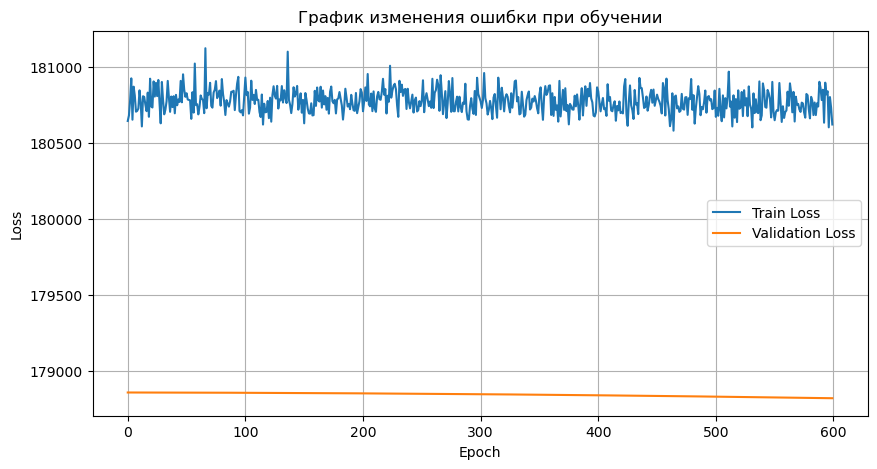

In [42]:
# Построение графика изменений потерь
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График изменения ошибки при обучении")
plt.legend()
plt.grid()
plt.show()

In [43]:
# Разделяем данные на тренировочную и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(df_encod, y_without_anomalies, test_size=0.2, random_state=42)

In [44]:
# Дополнительно Разбиваем данные: 80% в train, 20% в test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [49]:
# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

In [50]:
class HomeDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            # Возвращаем как тензоры
            return self.X[idx].float(), self.y[idx].float()
        return self.X[idx].float()

# Создаём датасеты
train_dataset = HomeDataset(X_train_tensor, y_train_tensor)
val_dataset = HomeDataset(X_val_tensor, y_val_tensor)  
test_dataset = HomeDataset(X_test_tensor, y_test_tensor)

In [51]:
# === 1. Устанавливаем лучшие параметры ===
best_config = {
    "learning_rate": 0.001,  # Увеличиваем learning rate
    "batch_size": 32,
    "dropout": 0.1,  # Уменьшаем Dropout
    "activation": "leaky_relu",  # Используем LeakyReLU
    "num_layers": 3,
    "optimizer": "Adam",
    "layers": 128,
    "weight_decay": 1e-5  # L2 регуляризация (чем больше значение, тем сильнее штраф за большие веса)
}


# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False)

# === 4. Определяем модель ===
class SimpleNN(nn.Module):
    def __init__(self, num_layers, hidden_size, dropout, activation, input_dim):
        super(SimpleNN, self).__init__()
        layers = []

        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_size))
            if activation == "leaky_relu":
                layers.append(nn.LeakyReLU(negative_slope=0.01))  # LeakyReLU с малым наклоном
            else:
                layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_size  # обновляем размер входа после каждого слоя
        
        layers.append(nn.Linear(hidden_size, 1))  # выходной слой
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Инициализируем модель
input_dim = X_encoded.shape[1]  # Получаем количество признаков из тестовых данных

# Инициализируем модель с правильным размером входа
model_2 = SimpleNN(
    num_layers=best_config["num_layers"],
    hidden_size=best_config["layers"],
    dropout=best_config["dropout"],
    activation=best_config["activation"],
    input_dim=input_dim  
).to(device)

# === 5. Определяем функцию потерь и оптимизатор ===
criterion = nn.MSELoss()  # Используем MSELoss
optimizer = optim.Adam(
    model_2.parameters(), 
    lr=best_config["learning_rate"], 
    weight_decay=best_config["weight_decay"]  # L2 регуляризация
)


# === 6. Создаём папку для логов TensorBoard ===
log_dir = f"tensorboard/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# === 7. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_2.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model_2.parameters(), clip_value=1.0)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Добавляем в список

    # === 8. Валидация ===
    model_2.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)  # Добавляем в список


    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # === 9. Логируем данные в TensorBoard ===
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Логируем градиенты
    for name, param in model_2.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model_2.state_dict()  # Сохраняем лучшие веса
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model_2.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель в папку с логами ===
model_path = os.path.join(log_dir, "final_model.pth")
torch.save(model_2.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

# Закрываем TensorBoard writer
writer.close()

/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Train Loss=38500386886.620689, Val Loss=37579429432.888885
Epoch 2: Train Loss=38483554868.965515, Val Loss=37566587562.666664
Epoch 3: Train Loss=38451797239.172417, Val Loss=37514978190.222221
Epoch 4: Train Loss=39127247059.862068, Val Loss=37381167559.111115
Epoch 5: Train Loss=38275663589.517242, Val Loss=37106117063.111115
Epoch 6: Train Loss=39139022706.758621, Val Loss=36616470528.000000
Epoch 7: Train Loss=36890899844.413795, Val Loss=35827326976.000000
Epoch 8: Train Loss=36305924872.827583, Val Loss=34647088014.222221
Epoch 9: Train Loss=35094749748.965515, Val Loss=32985206556.444443
Epoch 10: Train Loss=33396951604.965519, Val Loss=30763376412.444443
Epoch 11: Train Loss=30657779923.862068, Val Loss=27933469809.777779
Epoch 12: Train Loss=27264100740.413792, Val Loss=24499702670.222221
Epoch 13: Train Loss=23568910159.448277, Val Loss=20550843164.444443
Epoch 14: Train Loss=19424301320.827587, Val Loss=16299762232.888889
Epoch 15: Train Loss=15559950724.413794, Va

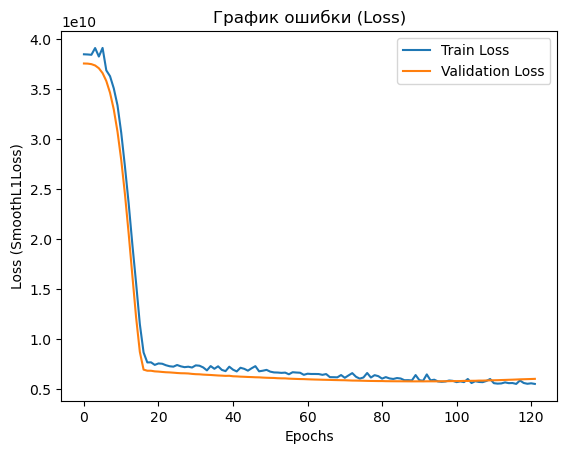

In [52]:
# График ошибки
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 5934452224.000000
Mean Absolute Error (MAE): 53081.759064
R²: 0.027399


/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([284])) that is different to the input size (torch.Size([284, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


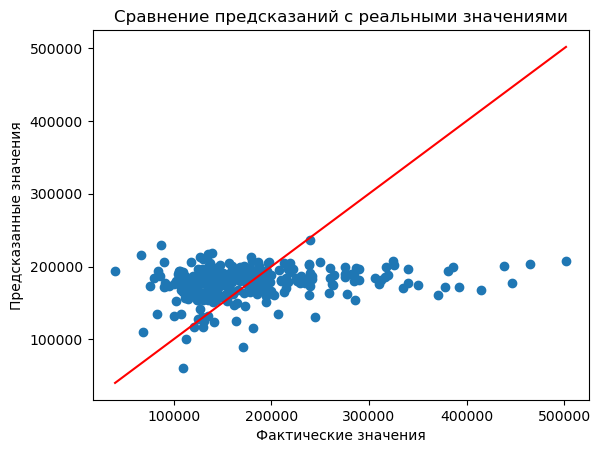

In [53]:
# Переводим модель в режим оценки
model_2.eval()

# Переменная для хранения общей потери
test_loss = 0.0
n_samples = 0

# Переменные для расчетов MAE и R²
y_true = torch.tensor(y_test.values)  # Преобразуем pandas.Series в torch.Tensor
y_pred = []

# Включаем отключение градиентов
with torch.no_grad():
    # Предсказания
    y_pred_tensor = model_2(X_test_tensor.to(device))  
    y_pred_tensor = y_pred_tensor.cpu().numpy()  # Переводим предсказания в numpy
    y_pred = y_pred_tensor

    # Вычисляем тестовую потерю
    criterion = nn.MSELoss()  # Потери для регрессии
    loss = criterion(torch.tensor(y_pred), y_test_tensor)  # Включаем реальное y
    test_loss += loss.item() * y_test_tensor.size(0)  # Умножаем на размер батча
    n_samples += y_test_tensor.size(0)

    # Средняя потеря
    avg_test_loss = test_loss / n_samples

# Вычисляем MAE и R²
mae = mean_absolute_error(y_true.numpy(), y_pred)  # Конвертируем y_true в numpy
r2 = r2_score(y_true.numpy(), y_pred)

# Выводим среднюю потерю, MAE и R²
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R²: {r2:.6f}")

# Строим график
plt.scatter(y_true.numpy(), y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')

# Линия идеального предсказания
plt.plot([min(y_true.numpy()), max(y_true.numpy())], [min(y_true.numpy()), max(y_true.numpy())], color='red') 

plt.show()

### Модель хоть и обучилась но обучение крайне плохо

In [54]:
model_forest_auto = RandomForestRegressor(n_estimators=100, random_state=42)
model_forest_auto.fit(X_train, y_train)
y_pred_auto = model_forest_auto.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_auto))
print("R²:", r2_score(y_test, y_pred_auto))

MAE: 56769.50813380281
R²: -0.05877275277280347


### Поскольку и лес очень плохо отработал на наших данныз то autoencoder только ухудшил наши данные

## Попробуем обучение на чистых нормализованных данных 

## Для начала попробуем что покажет лес на этих данных

In [81]:
# Разделяем данные на тренировочную, валидационную и тестовую выборки
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_scaler, y_without_anomalies, test_size=0.2, random_state=42)
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_train_log, y_train_log, test_size=0.2, random_state=42)



In [59]:
model_forest_clear = RandomForestRegressor(n_estimators=100, random_state=42)
model_forest_clear.fit(X_train_log, y_train_log)
y_pred_clear = model_forest_clear.predict(X_test_log)

print("MAE:", mean_absolute_error(y_test_log, y_pred_clear))
print("R²:", r2_score(y_test_log, y_pred_clear))

MAE: 15493.223309859155
R²: 0.9025145718977163


In [93]:
model_lr = LinearRegression()
model_lr.fit(X_train_log, y_train_log)
preds_lr = model_lr.predict(X_test_log)

print("R² (Linear Regression):", r2_score(y_test_log, preds_lr))
print("MAE (Linear Regression):", mean_absolute_error(y_test_log, preds_lr))

R² (Linear Regression): 0.8719756743973239
MAE (Linear Regression): 18817.422552939166


### Так как у RandomForestRegressor данные поулчились вполне приемлимые значит проблема:
1. автоэнкодер - не помогает а только ухудшает данные
2. Проверить распеределение целевой переменной и если оно не симметично - поробовать логарифимировать его

In [61]:
y_without_anomalies.describe()

count      1416.000000
mean     180402.368644
std       75312.201459
min       34900.000000
25%      130000.000000
50%      163945.000000
75%      213625.000000
max      625000.000000
Name: SalePrice, dtype: float64

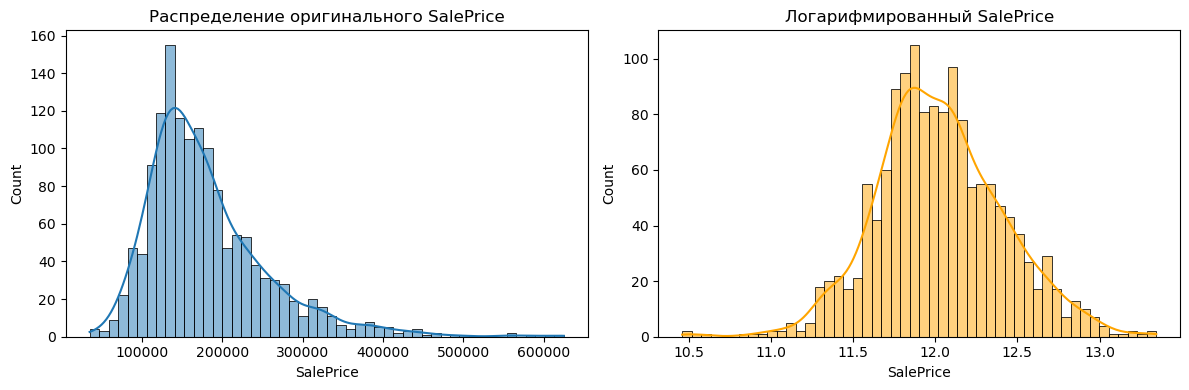

In [62]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(y_without_anomalies, bins=50, kde=True)
plt.title("Распределение оригинального SalePrice")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(y_without_anomalies), bins=50, kde=True, color='orange')
plt.title("Логарифмированный SalePrice")

plt.tight_layout()
plt.show()

In [ ]:
# # Применяем log1p к целевой переменной - проверили получилось плорхо
# y_train_log = np.log1p(y_train_log)
# y_test_log = np.log1p(y_test_log)


In [82]:
# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train_log, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_log, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_log.values.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_log, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_log.values.reshape(-1, 1), dtype=torch.float32)

In [83]:
# Проверим размеры тензоров
print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_val_tensor shape: {X_val_tensor.shape}')
print(f'y_val_tensor shape: {y_val_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

X_train_tensor shape: torch.Size([905, 76])
y_train_tensor shape: torch.Size([905, 1])
X_val_tensor shape: torch.Size([227, 76])
y_val_tensor shape: torch.Size([227, 1])
X_test_tensor shape: torch.Size([284, 76])
y_test_tensor shape: torch.Size([284, 1])


In [87]:
# Создаём датасеты
train_dataset_log = HomeDataset(X_train_tensor, y_train_tensor)
val_dataset_log = HomeDataset(X_val_tensor, y_val_tensor)  
test_dataset_log = HomeDataset(X_test_tensor, y_test_tensor)

In [88]:
# === 1. Устанавливаем лучшие параметры ===
best_config_2 = {
    "learning_rate": 0.001,  # Увеличиваем learning rate
    "batch_size": 32,
    "dropout": 0.1,  # Уменьшаем Dropout
    "activation": "leaky_relu",  # Используем LeakyReLU
    "num_layers": 3,
    "optimizer": "Adam",
    "layers": 128,
    "weight_decay": 1e-5  # L2 регуляризация (чем больше значение, тем сильнее штраф за большие веса)
}

# === 2. Определяем устройство ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === 3. Подготовка данных ===
train_loader = DataLoader(train_dataset_log, batch_size=best_config["batch_size"], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset_log, batch_size=best_config["batch_size"], shuffle=False, drop_last=True)


class SimpleNN_2(nn.Module):
    def __init__(self, num_layers, hidden_size, dropout, activation, input_dim):
        super(SimpleNN_2, self).__init__()
        layers = []

        # Первый слой должен принимать размерность входных данных
        layers.append(nn.Linear(input_dim, hidden_size))  # input_dim == 76
        if activation == "leaky_relu":
            layers.append(nn.LeakyReLU(negative_slope=0.01))
        else:
            layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Добавление последующих скрытых слоев
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if activation == "leaky_relu":
                layers.append(nn.LeakyReLU(negative_slope=0.01))
            else:
                layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # Выходной слой
        layers.append(nn.Linear(hidden_size, 1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)  # Используем self.model, а не отдельные слои
        return x

# Инициализируем модель
input_dim = X_train_tensor.shape[1]  # 76 признаков

model_log = SimpleNN_2(
    num_layers=best_config_2["num_layers"],
    hidden_size=best_config_2["layers"],
    dropout=best_config_2["dropout"],
    activation=best_config_2["activation"],
    input_dim=X_train_tensor.shape[1] 
).to(device)

# === 5. Определяем функцию потерь и оптимизатор ===
criterion = nn.MSELoss()  # Используем MSELoss
optimizer = optim.Adam(
    model_log.parameters(), 
    lr=best_config["learning_rate"], 
    weight_decay=best_config["weight_decay"]  # L2 регуляризация
)

# === 6. Создаём папку для логов TensorBoard ===
log_dir = f"tensorboard/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# === 7. Обучение модели ===
epochs = 600
best_val_loss = float("inf")
patience = 30
epochs_no_improve = 0
best_model_wts = None
train_losses_log = []
val_losses_log = []

for epoch in range(epochs):
    model_log.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_log(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model_log.parameters(), clip_value=0.1)  # ограничение градиентов
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses_log.append(avg_train_loss)  # Добавляем в список

    # === 8. Валидация ===
    model_log.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_log(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses_log.append(avg_val_loss)  # Добавляем в список


    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # === 9. Логируем данные в TensorBoard ===
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Логируем градиенты
    for name, param in model_log.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = model_log.state_dict()  # Сохраняем лучшие веса
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# === 10. Загружаем лучшие веса модели ===
if best_model_wts is not None:
    model_log.load_state_dict(best_model_wts)
    print("✅ Загружены лучшие веса модели.")

# === 11. Сохраняем обученную модель в папку с логами ===
model_path = os.path.join(log_dir, "final_model.pth")
torch.save(model_log.state_dict(), model_path)
print(f"📁 Модель сохранена в '{model_path}'")

# Закрываем TensorBoard writer
writer.close()

Epoch 1: Train Loss=38539227648.000000, Val Loss=36281834752.000000
Epoch 2: Train Loss=38609058011.428574, Val Loss=36241056000.000000
Epoch 3: Train Loss=38329195081.142860, Val Loss=36085510144.000000
Epoch 4: Train Loss=38194692315.428574, Val Loss=35683352320.000000
Epoch 5: Train Loss=37508411026.285713, Val Loss=34856201472.000000
Epoch 6: Train Loss=36237005312.000000, Val Loss=33385963776.000000
Epoch 7: Train Loss=34128651117.714287, Val Loss=31056162560.000000
Epoch 8: Train Loss=30991531812.571430, Val Loss=27723362816.000000
Epoch 9: Train Loss=26543207131.428570, Val Loss=23347188992.000000
Epoch 10: Train Loss=21384410258.285713, Val Loss=18168442624.000000
Epoch 11: Train Loss=15510993773.714285, Val Loss=12934497664.000000
Epoch 12: Train Loss=10143693476.571428, Val Loss=9056799872.000000
Epoch 13: Train Loss=7758715318.857142, Val Loss=7720092608.000000
Epoch 14: Train Loss=6779001581.714286, Val Loss=6854758144.000000
Epoch 15: Train Loss=5856607597.714286, Val Loss

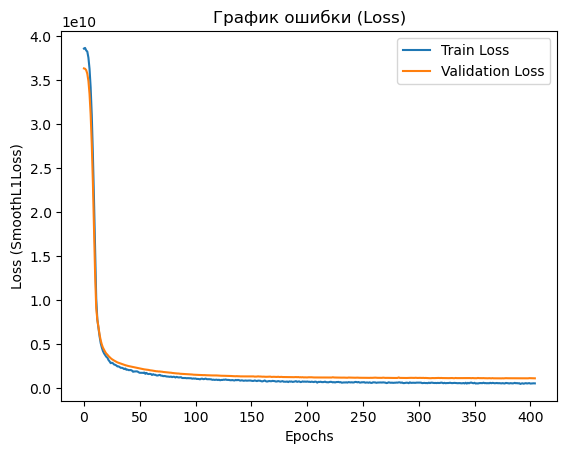

In [89]:
# График ошибки
plt.plot(train_losses_log, label='Train Loss')
plt.plot(val_losses_log, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1Loss)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

Test Loss: 1008689408.000000
MAE (log): 19913.396484
R² (log): 0.814730


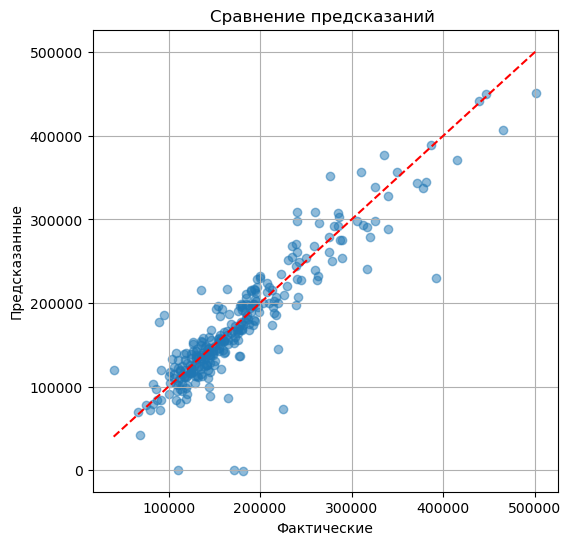

In [94]:
# Предсказания
with torch.no_grad():
    y_pred_log = model_log(X_test_tensor.to(device)).cpu().numpy().flatten()
    y_true_log = y_test_tensor.cpu().numpy().flatten()

# MSE, MAE и R² прямо в log-пространстве
loss = nn.MSELoss()(torch.tensor(y_pred_log), torch.tensor(y_true_log))
mae = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

print(f"Test Loss: {loss.item():.6f}")
print(f"MAE (log): {mae:.6f}")
print(f"R² (log): {r2:.6f}")

# График
plt.figure(figsize=(6, 6))
plt.scatter(y_true_log, y_pred_log, alpha=0.5)
plt.plot([y_true_log.min(), y_true_log.max()],
         [y_true_log.min(), y_true_log.max()],
         color='red', linestyle='--')
plt.xlabel("Фактические")
plt.ylabel("Предсказанные")
plt.title("Сравнение предсказаний ")
plt.grid(True)
plt.show()

PermutationExplainer explainer: 285it [00:11,  2.82it/s]                                                                                                                                                                                                                                                            


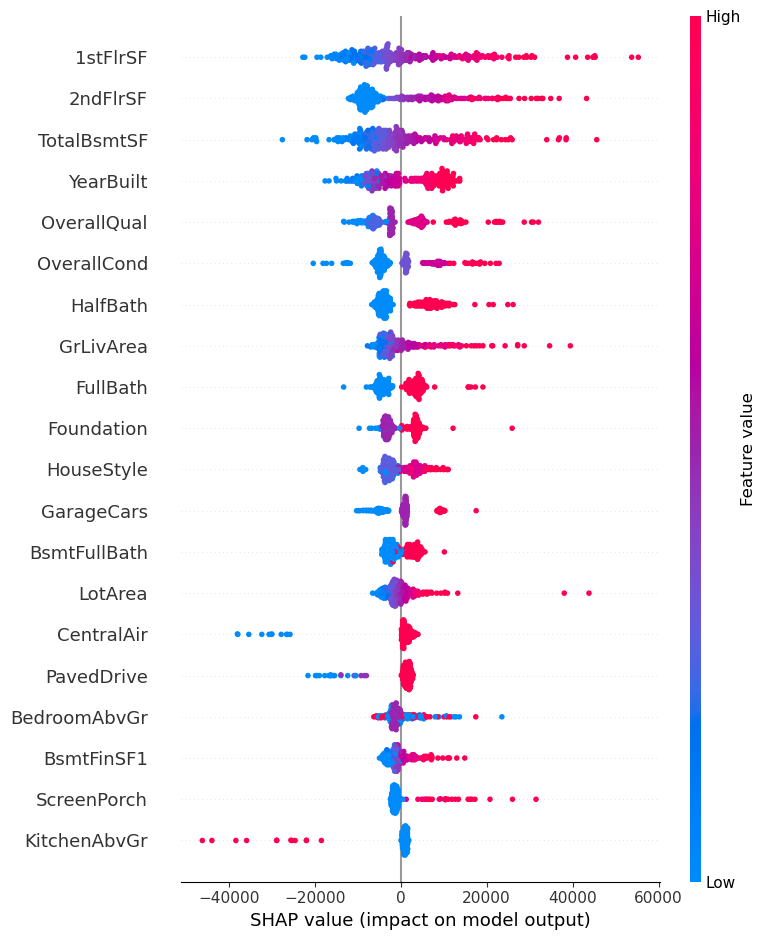

In [91]:
X_test_tensor = torch.tensor(X_test_log, dtype=torch.float32)

# Функция для выполнения предсказания через модель
def model_predict(x):
    x = torch.tensor(x, dtype=torch.float32)  # Если x это numpy.ndarray
    x = x.to(device)  # Переносим на тот же девайс, где модель
    model_log.eval()  # Убедитесь, что модель в режиме "оценки"
    with torch.no_grad():
        return model_log(x).cpu().numpy()  # Возвращаем на CPU и конвертируем в numpy

# Преобразуем X_test_tensor в numpy массив
X_test_numpy = X_test_tensor.cpu().numpy()

# Инициализируем SHAP объяснитель с кастомной функцией предсказания
my_explainer = shap.Explainer(model_predict, X_test_numpy)  # X_test_numpy - данные для объяснения

# Получаем SHAP значения
shap_values = my_explainer(X_test_numpy)

# Строим график
shap.summary_plot(shap_values, X_test_numpy, feature_names=df_x_scaler.columns)